# Homework-2: 

`ANN training in Keras or Pytorch & Hyper-parameter tuning`

## Overview 

* Classification is one of the most common forms of supervised machine learning 
* In this homework we will explore "model tuning" for the case of a multi-class classification problem, as applied to the MNIST data set
* `You can do this assignment in either Keras OR PyTorch` (or both), it is your choice.

## Submission 

* You need to upload TWO documents to Canvas when you are done
  * (1) A PDF (or HTML) of the completed form of the `HW-2.ipynb` document 
* The final uploaded version should NOT have any code-errors present 
* All outputs must be visible in the uploaded version, including code-cell outputs, images, graphs, etc

`IMPORTANT`: THERE ARE MANY WAYS TO DO THIS, SO FEEL FREE TO DEVIATE SLIGHTLY FROM THE EXACT DETAILS, BUT THE OVERALL RESULT AND FLOW SHOULD MATCH WHAT IS OUTLINED BELOW. 

**IF YOU ARE BUMPING UP AGAINST COMPUTE LIMITS (e.g LONG RUNTIMES), CONSIDER USING GOOGLE COLAB OR A COLAB PROFESSIONAL ACCOUNT TO RUN THE CODE. IF THIS STILL IS NOT SUFFICIENT, YOU CAN DOWNSAMPLE THE DATA AND PERFORM A LESS COMPREHENSIVE HYPER-PARAMETER SEARCH.**

In [1]:
# Import
import torch
from torch import nn
import torch.nn.init as init
from torch.utils.data import DataLoader, Subset
from torch.utils.data import random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting seed
seed = 6600
torch.manual_seed(seed)

## HW-2.1: Data preparation

* Normalize the data as needed
* Partition data into training, validation, and test (i.e. leave one out CV)
  * One option to do this is to give these arrays global scope so they are seen inside the training function (so they don't need to be passed to functions)
* **Optional but recommended:** Create a K-fold cross validation data set, rather than just doing leave one out
* Do any other preprocessing you feel is needed

In [2]:
### Download training and test data from open datasets.
## Transform to normalize to [-1,1]
# Normalize to [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))  
])

## Importing Training and Test data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,        # Switch to True if downloading data instead of importing
    transform=transform,
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=transform,
)

## Defining folds for k-fold cross validation in training loop 
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# explore data-set object
print("\n TYPE:\n",type(training_data))
print("\n SUMMARY:\n",training_data)
print("\n SUMMARY:\n",test_data)
print("\n ATTRIBUTES:\n",training_data.__dict__.keys())
print("\n FIRST DATA POINT:\n",)
img, label = training_data[0]
print(img.shape,label)
print(len(training_data))


 TYPE:
 <class 'torchvision.datasets.mnist.FashionMNIST'>

 SUMMARY:
 Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

 SUMMARY:
 Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

 ATTRIBUTES:
 dict_keys(['root', 'transform', 'target_transform', 'transforms', 'train', 'data', 'targets'])

 FIRST DATA POINT:

torch.Size([1, 28, 28]) 9
60000


## HW-2.2: Generalized model

* Create a `General` model function (or class) that takes hyper-parameters and evaluates the model
  * The function should work with a set of hyper parameters than can be easily be controlled and varied by the user (for later parameter tuning)
  * This should work for the training, test, and validation set 
* Feel free to recycle code from the lab assignments and demo's  
* Use the deep learning best practices that we discussed in class. 
* Document what is going on in the code, as needed, with narrative markdown text between cells.

In [3]:
# Create general model class
class GeneralModel(nn.Module):
    def __init__(self, image_size=(28,28), num_classes=10, layer_sizes=(32,32),activation="relu",dropout_rate=0):
        super().__init__()
        self.flatten = nn.Flatten()

        # Building layers dynamically based on layer sizes
        layers = []
        input_size = image_size[0] * image_size[1]

        for hidden_size in layer_sizes:
            # Linear layer
            layers.append(nn.Linear(input_size, hidden_size))

            # Activation (either ReLU or Sigmoid)
            if activation == "relu":
                layers.append(nn.ReLU())
            elif activation == "sigmoid":
                layers.append(nn.Sigmoid())
            elif activation == "tanh":
                layers.append(nn.Tanh())
            else:
                raise ValueError(f"Invalid activation {activation}. Activation must be either relu, sigmoid, or tanh")
            
            # Dropout rate
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))

            # Set input size for next layer
            input_size = hidden_size

        # Final output layer
        layers.append(nn.Linear(input_size,num_classes))

        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self,x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x 

## HW-2.3: Model training function

* You can do this in either a function (or python class), or however you think is best. 
* **Create a training function** (or class) that takes hyper-parameter choices and trains the model
  * If you are doing "leave one out", your training function only needs to do one training per hyper-parameter choice
  * If you are doing K-fold cross validation, you should train the model K times for each hyper-parameter choice, and report the average result cross the training runs at the end (this is technically a better practice but requires more computation). 
  * Use a dense feed forward ANN model, with the correct output layer activation, and correct loss function
  * `You MUST use early stopping` inside the function, otherwise it defeats the point
  * **Have at least the following hyper-parameters as inputs to this function** 
    * L1 regularization constant, L2 regularization constant, dropout rate 
    * Learning rate
    * Weight Initialization: Fully random vs Xavier Weight Initialization
    * Hidden layer activation function choice (use relu, sigmoid, or tanh)
    * Number and size of ANN hidden layers 
    * Optimizer choice, have at least three included (Adam, SGD, or RmsProp)
    * You can wrap all of the hyper-parameter arguments into a dictionary, or do it however you want  
  * **Visualization**
    * Include a boolean parameter as a function input that controls whether visualization is created or not
    * If `true`, Monitor training and validation throughout training by plotting
    * Report a confusion matrix 
  * Return the final training and validation error (averaged if using K-fold)
    * again, you must use early stopping to report the best training/validation loss without over-fitting
* Depending how you do this, it can be a lot of computation, start small and scale up and consider using Co-lab 
  

In [4]:
class TrainModel:
    def __init__(self, learning_rate=0.01, layer_sizes=(32,32), optimizer="adam", activation = "relu",
                 weight_init="random", l1_lambda=0.0, l2_lambda=0.0, dropout_rate=0.0, device="cpu",
                 visualize=False, verbose=1, show_confusion=False):
        
        # Store hyper-parameters
        self.device         = device
        self.dropout_rate   = dropout_rate
        self.learning_rate  = learning_rate
        self.weight_init    = weight_init
        self.optimizer      = optimizer
        self.layer_sizes    = layer_sizes
        self.activation     = activation
        self.l1_lambda      = l1_lambda
        self.l2_lambda      = l2_lambda
        self.visualize      = visualize 
        self.verbose        = verbose
        self.show_confusion = show_confusion

        # Initialize model
        self.model = GeneralModel(
            image_size=(28, 28),
            num_classes=10,
            layer_sizes = self.layer_sizes,
            activation  = self.activation,
            dropout_rate= self.dropout_rate
        ).to(self.device)

        # Apply weight initialization
        self._initialize_weights()

        # Initialize loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # Initialize optimizer
        self._setup_optimizer()

        # Initialize history tracking
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
        # For k-fold CV results
        self.kfold_results = []
        
        # Track best model 
        self.best_model_state = None
        self.best_val_acc = 0.0

    ##################################
    ######## Set up optimizer ########
    ##################################
    def _setup_optimizer(self):
        if self.optimizer == "adam":
            self.opt = torch.optim.Adam(
                self.model.parameters(),
                lr=self.learning_rate,
                weight_decay=self.l2_lambda
            )
        elif self.optimizer == "sgd":
            self.opt = torch.optim.SGD(
                self.model.parameters(),
                lr=self.learning_rate,
                momentum=0.9,
                weight_decay=self.l2_lambda  
            )
        elif self.optimizer == "rmsprop":
            self.opt = torch.optim.RMSprop(
                self.model.parameters(),
                lr=self.learning_rate,
                alpha=0.99,
                momentum=0.0,
                weight_decay=self.l2_lambda
            )
        else:
            raise ValueError(f"Unknown optimizer: {self.optimizer}")

    ##########################################  
    ### Reset model to original parameters ###
    ##########################################
    def reset_model(self):
        self.model = GeneralModel(
            image_size=(28, 28),
            num_classes=10,
            layer_sizes = self.layer_sizes,
            activation  = self.activation,
            dropout_rate= self.dropout_rate
        ).to(self.device)

        # Apply weight initialization
        self._initialize_weights()

        # Initialize optimizer
        self._setup_optimizer()

        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }

        # Reset best model
        self.best_val_acc = 0.0
        self.best_model_state = None

    #########################################
    ### Apply Weight Initialization #########
    #########################################
    def _initialize_weights(self):
        if self.weight_init == "xavier":
            for module in self.model.modules():
                if isinstance(module, nn.Linear):
                    nn.init.xavier_uniform_(module.weight)
                    if module.bias is not None:
                        nn.init.zeros_(module.bias)
        elif self.weight_init == "random":
            # PyTorch's default initialization (already applied)
            pass
        else:
            raise ValueError(f"Unknown weight initialization: {self.weight_init}. Must be random or xavier")

    #################################
    ######## Train one epoch ########
    #################################
    def train_epoch(self, train_loader):
        """Training one epoch"""
        self.model.train()
        train_loss = 0
        correct    = 0
        total      = 0

        for images, labels in train_loader:
            images, labels = images.to(self.device), labels.to(self.device)

            # Forward pass
            outputs = self.model(images)
            loss = self.loss_fn(outputs, labels)

            # L1 Regularization 
            if self.l1_lambda > 0:
                l1_penalty = 0
                for param in self.model.parameters():
                    l1_penalty += torch.sum(torch.abs(param))
                loss = loss + self.l1_lambda * l1_penalty

            # Backward pass 
            self.opt.zero_grad() 
            loss.backward()
            self.opt.step()

            # Track metrics 
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss and accuracy for the epoch 
        avg_loss = train_loss / len(train_loader)
        accuracy = 100 * correct / total

        return avg_loss, accuracy
    
    ######################################
    ##### Evaluate model performance #####
    ######################################
    def evaluate(self, data_loader):
        """Evaluate model on validation or test set"""
        # Set to evaluation mode 
        self.model.eval()  
        eval_loss = 0
        correct = 0
        total = 0
        
        # Don't compute gradients
        with torch.no_grad():  
            for images, labels in data_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                # Forward pass
                outputs = self.model(images)
                loss = self.loss_fn(outputs, labels)
                
                # Track metrics
                eval_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_loss = eval_loss / len(data_loader)
        accuracy = 100 * correct / total
        return avg_loss, accuracy

    #########################
    ##### Fit the model #####
    #########################
    def fit(self, train_loader, val_loader, epochs, patience=None):
        best_val_loss = float('inf')
        patience_counter = 0
        best_epoch = 0

        for epoch in range(epochs):
            # Train model
            train_loss, train_acc = self.train_epoch(train_loader)
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)

            # Validate 
            val_loss, val_acc = self.evaluate(val_loader)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            # Track best model 
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc 
                self.best_model_state = self.model.state_dict().copy()
                best_epoch = epoch 

            # Print progress
            if self.verbose >= 2:
                if epoch % 5 == 0 or epoch == epochs - 1:
                    print(f"Epoch {epoch+1}/{epochs} - "
                        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
                        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
                
            # Early stopping
            if patience is not None:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    if self.verbose >= 1:
                        print(f"\nEarly stopping triggered after {epoch+1} epochs!")
                        print(f"Best validation loss: {best_val_loss:.4f}")
                    break

        # Load best model weights and print details
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            if self.verbose >= 1:
                print(f"\nLoaded best model from Epoch {best_epoch+1}:")
                print(f"  Train Loss: {self.history['train_loss'][best_epoch]:.4f}, "
                    f"Train Acc: {self.history['train_acc'][best_epoch]:.2f}%",
                    f"  Val Loss: {self.history['val_loss'][best_epoch]:.4f}, "
                    f"Val Acc: {self.history['val_acc'][best_epoch]:.2f}%")

        # Visualize training history if True
        if self.visualize:
            self.plot_history()
            
        return self.history
    
    ##################################
    ### Run with K-Fold Validation ###
    ##################################
    def run_kfold_cv(self, train_data, epochs, batch_size=64, patience=None):
        fold_results = []

        # Temporarily disable visualization during fold training
        original_visualize = self.visualize
        self.visualize = False  

        for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data)):
            if self.verbose >= 1:  # Minimal: show fold number
                print(f"\n*** FOLD {fold + 1}/{kfold.n_splits} ***")

            # Reset model for this fold
            self.reset_model()

            # Create data loaders for this fold
            train_subset = Subset(train_data, train_ids)
            val_subset   = Subset(train_data, val_ids)

            if self.device == "cuda":
                train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,num_workers=8,pin_memory=True, persistent_workers=False)
                val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False,num_workers=8,pin_memory=True, persistent_workers=False)
            else:
                train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

            # Train on this fold with early stopping
            history = self.fit(train_loader, val_loader, epochs, patience=patience)

            # Store results
            fold_results.append({
                'fold': fold + 1,
                'final_train_acc': history['train_acc'][-1],
                'final_val_acc': history['val_acc'][-1],
                'best_val_acc': self.best_val_acc,
                'epochs_trained': len(history['train_loss']),
                'history': history
            })

            # Plot confusion matrix for this fold if visualize=True
            if self.show_confusion:
                print(f"\nConfusion Matrix for Fold {fold + 1}:")
                class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
                self.plot_confusion_matrix(val_loader, class_names=class_names)

            # Cleanup
            del train_loader
            del val_loader
            gc.collect()


        # Store all fold results
        self.kfold_results = fold_results

        # Plot aggregated history if visualize was True
        if original_visualize:
            self._plot_kfold_history(fold_results)

        # Restore original setting
        self.visualize = original_visualize
        
        # Print summary
        if self.verbose >= 1:
            print(f"\n{'='*50}")
            print("K-FOLD CROSS VALIDATION SUMMARY")
            print(f"{'='*50}")

            val_accs = [r['final_val_acc'] for r in fold_results]
            best_val_accs = [r['best_val_acc'] for r in fold_results]

            print(f"Best Val Acc: {np.mean(best_val_accs):.2f}% ± {np.std(best_val_accs):.2f}%")
            print(f"Final Epoch Val Acc: {np.mean(val_accs):.2f}% ± {np.std(val_accs):.2f}%")
        
        return fold_results
    
    ###############################
    ### Plotting K-Fold History ###
    ###############################

    def _plot_kfold_history(self, fold_results):
        """Plot average training history across all folds"""
        # Find maximum number of epochs across all folds
        max_epochs = max(r['epochs_trained'] for r in fold_results)
        
        # Collect histories (pad shorter ones with NaN)
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []
        
        for result in fold_results:
            hist = result['history']
            train_losses.append(hist['train_loss'])
            val_losses.append(hist['val_loss'])
            train_accs.append(hist['train_acc'])
            val_accs.append(hist['val_acc'])
        
        # Calculate mean and std across folds for each epoch
        # (only up to the minimum epoch count)
        min_epochs = min(len(tl) for tl in train_losses)
        
        train_loss_mean = np.mean([tl[:min_epochs] for tl in train_losses], axis=0)
        train_loss_std = np.std([tl[:min_epochs] for tl in train_losses], axis=0)
        val_loss_mean = np.mean([vl[:min_epochs] for vl in val_losses], axis=0)
        val_loss_std = np.std([vl[:min_epochs] for vl in val_losses], axis=0)
        
        train_acc_mean = np.mean([ta[:min_epochs] for ta in train_accs], axis=0)
        train_acc_std = np.std([ta[:min_epochs] for ta in train_accs], axis=0)
        val_acc_mean = np.mean([va[:min_epochs] for va in val_accs], axis=0)
        val_acc_std = np.std([va[:min_epochs] for va in val_accs], axis=0)
        
        epochs = range(1, min_epochs + 1)
        
        # Plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot loss with shaded std
        ax1.plot(epochs, train_loss_mean, label='Train Loss', linewidth=2)
        ax1.fill_between(epochs, train_loss_mean - train_loss_std, 
                        train_loss_mean + train_loss_std, alpha=0.3)
        ax1.plot(epochs, val_loss_mean, label='Val Loss', linewidth=2)
        ax1.fill_between(epochs, val_loss_mean - val_loss_std, 
                        val_loss_mean + val_loss_std, alpha=0.3)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'Training and Validation Loss (averaged over {len(fold_results)} folds)')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracy with shaded std
        ax2.plot(epochs, train_acc_mean, label='Train Acc', linewidth=2)
        ax2.fill_between(epochs, train_acc_mean - train_acc_std, 
                        train_acc_mean + train_acc_std, alpha=0.3)
        ax2.plot(epochs, val_acc_mean, label='Val Acc', linewidth=2)
        ax2.fill_between(epochs, val_acc_mean - val_acc_std, 
                        val_acc_mean + val_acc_std, alpha=0.3)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title(f'Training and Validation Accuracy (averaged over {len(fold_results)} folds)')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

    
    ########################
    ### Confusion Matrix ###
    ########################
    def plot_confusion_matrix(self, data_loader, class_names=None):
        # Get all predictions and labels
        self.model.eval()
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for images, labels in data_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())

        # Compute confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)

        # Plot
        if class_names is None:
            class_names = [str(i) for i in range(10)]

        fig, ax = plt.subplots(figsize=(10,8))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=ax, cmap='Blues', values_format='d')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()

        return cm
        
    #############################
    ### Plot Training History ###
    #############################
    def plot_history(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot loss 
        ax1.plot(self.history['train_loss'], label = "Train Loss")
        ax1.plot(self.history['val_loss'], label = "Val Loss")
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True)

        # Plot accuracy
        ax2.plot(self.history['train_acc'], label='Train Acc')
        ax2.plot(self.history['val_acc'], label='Val Acc')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    #########################
    ### Evaluate Test Set ###
    #########################
    def evaluate_test_set(self, test_loader):
        # Get test loss and accuracy
        test_loss, test_acc = self.evaluate(test_loader)

        print(f"\nTest Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_acc:.2f}%")
        
        # Plot confusion matrix if visualization is enabled
        if self.show_confusion:
            print("\nTest Set Confusion Matrix:")
            class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
            self.plot_confusion_matrix(test_loader, class_names=class_names)
        
        return test_loss, test_acc

## HW-2.4: Hyper-parameter tuning

* Keep detailed records of hyper-parameter choices and associated training & validation errors
* Think critically and visualize the results of the search as needed

* **Do each of these in a different sub-section of your notebook**
  
### Explore hyper-parameter choice-0
  * for hidden activation=Relu, hidden layers = [32,32], optimizer=adam
  * Vary the learning rate via a grid search pattern
  * Plot training and validation error as a function of the learning rate
  * Repeat this exercise for both random and Xavier weight initialization 
  

Using cuda device

**********************************************************************
WEIGHT INITIALIZATION: RANDOM
**********************************************************************

Testing Learning Rate: 0.0001 with random initialization


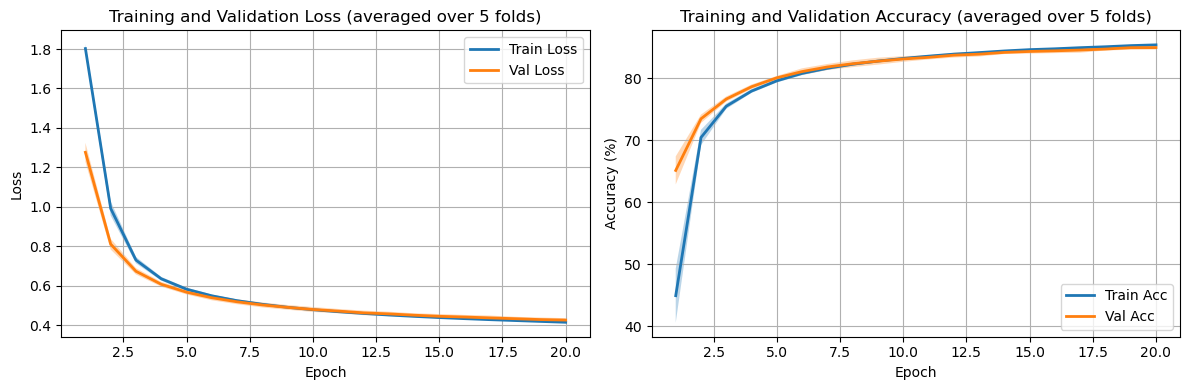


Average Results: Train Loss=0.4148, Val Loss=0.4259
                 Train Acc=85.42%, Val Acc=84.98%

Testing Learning Rate: 0.001 with random initialization


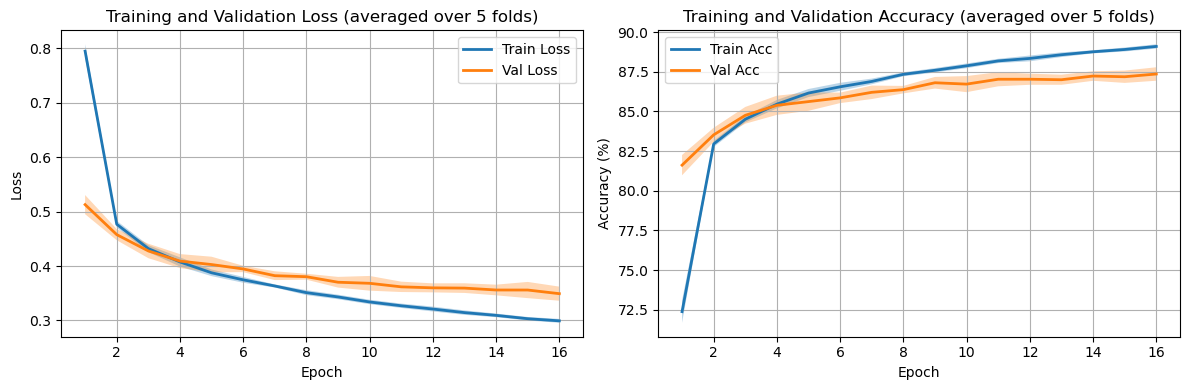


Average Results: Train Loss=0.2849, Val Loss=0.3501
                 Train Acc=89.59%, Val Acc=87.40%

Testing Learning Rate: 0.005 with random initialization


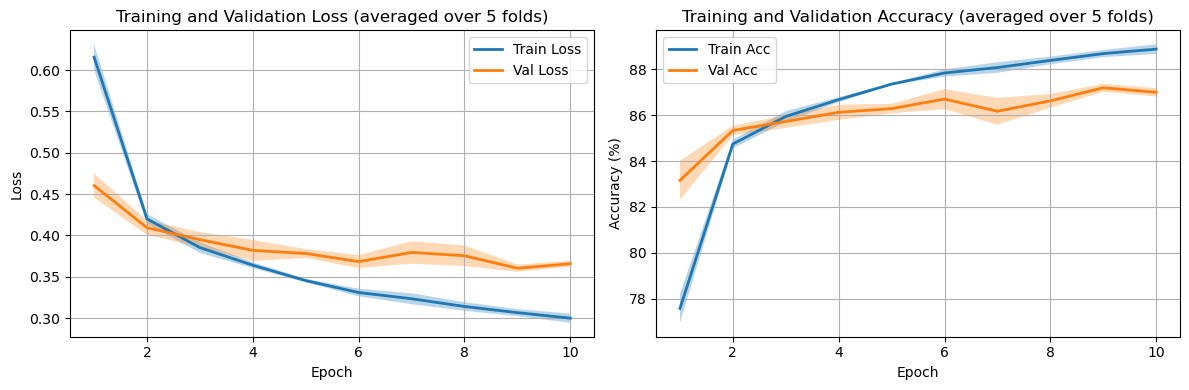


Average Results: Train Loss=0.2882, Val Loss=0.3689
                 Train Acc=89.31%, Val Acc=86.94%

Testing Learning Rate: 0.01 with random initialization


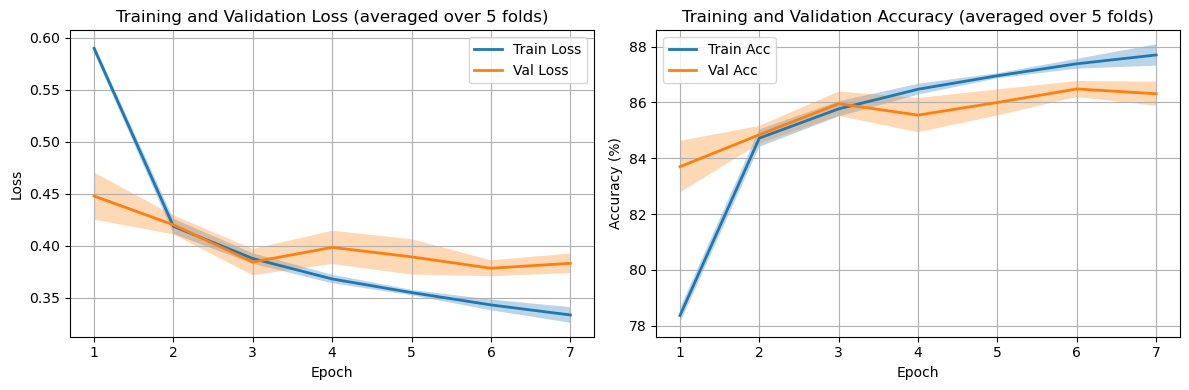


Average Results: Train Loss=0.3120, Val Loss=0.3818
                 Train Acc=88.51%, Val Acc=86.52%

Testing Learning Rate: 0.05 with random initialization


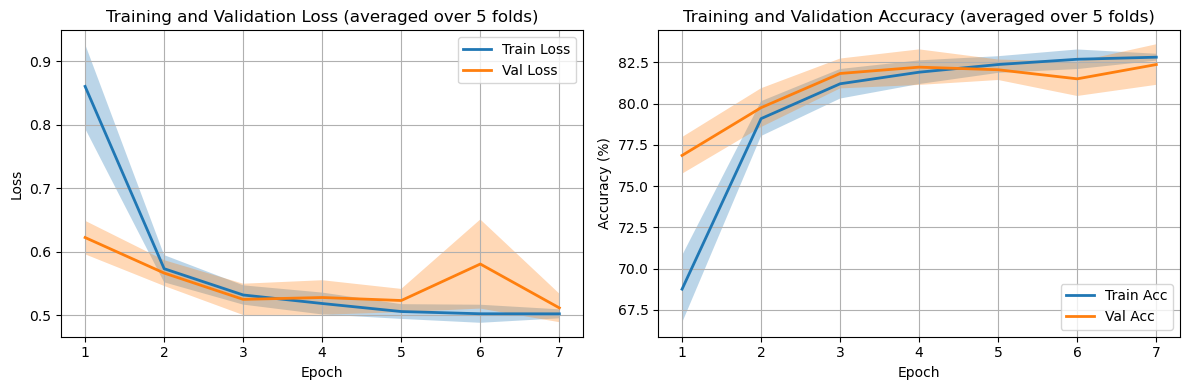


Average Results: Train Loss=0.5127, Val Loss=0.5568
                 Train Acc=82.83%, Val Acc=81.64%

**********************************************************************
WEIGHT INITIALIZATION: XAVIER
**********************************************************************

Testing Learning Rate: 0.0001 with xavier initialization


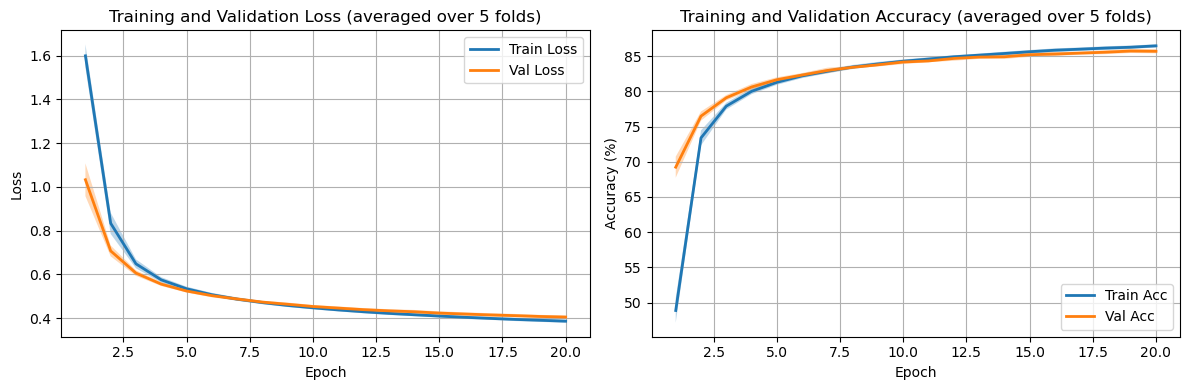


Average Results: Train Loss=0.3857, Val Loss=0.4044
                 Train Acc=86.45%, Val Acc=85.68%

Testing Learning Rate: 0.001 with xavier initialization


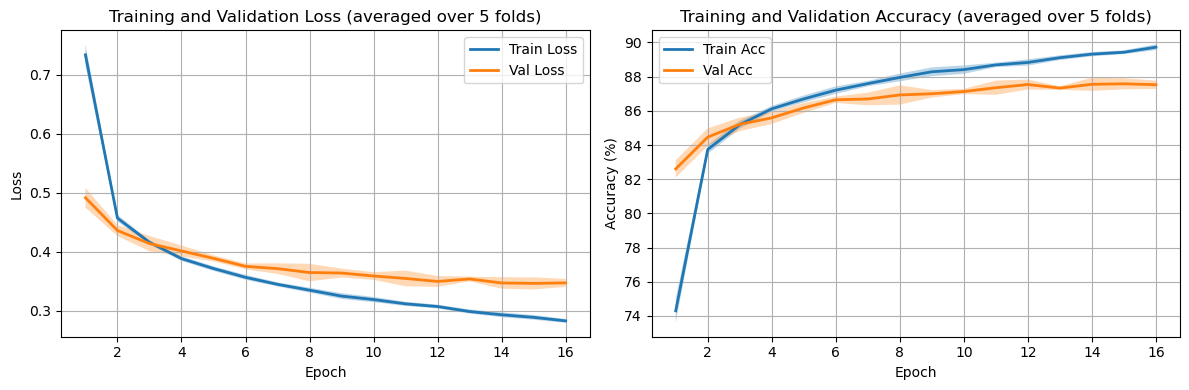


Average Results: Train Loss=0.2711, Val Loss=0.3451
                 Train Acc=90.09%, Val Acc=87.73%

Testing Learning Rate: 0.005 with xavier initialization


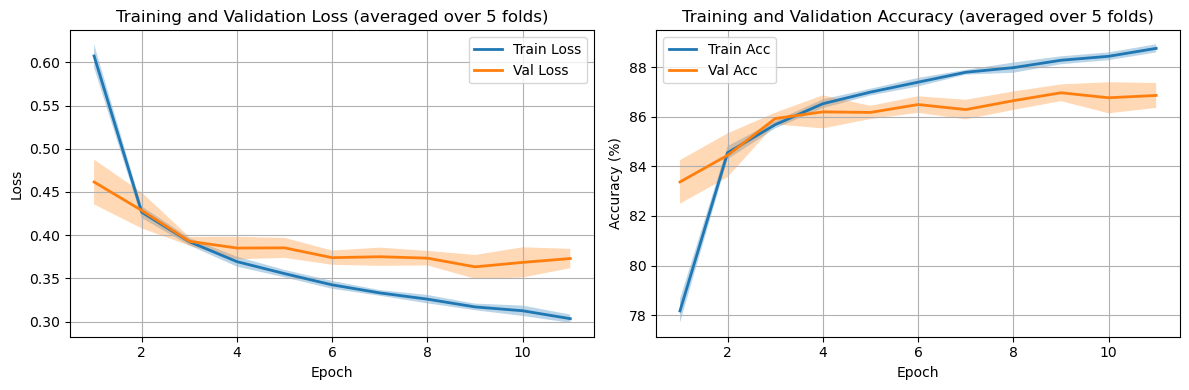


Average Results: Train Loss=0.2907, Val Loss=0.3671
                 Train Acc=89.21%, Val Acc=87.03%

Testing Learning Rate: 0.01 with xavier initialization


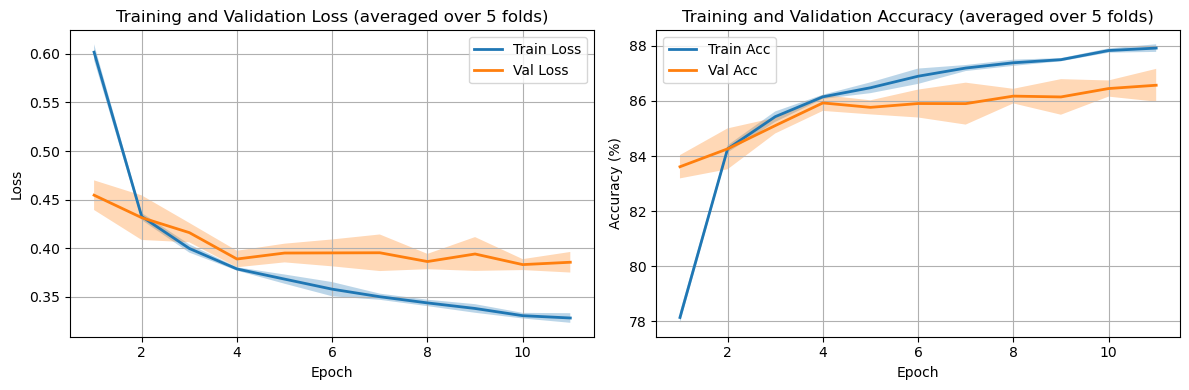


Average Results: Train Loss=0.3183, Val Loss=0.4154
                 Train Acc=88.26%, Val Acc=85.62%

Testing Learning Rate: 0.05 with xavier initialization


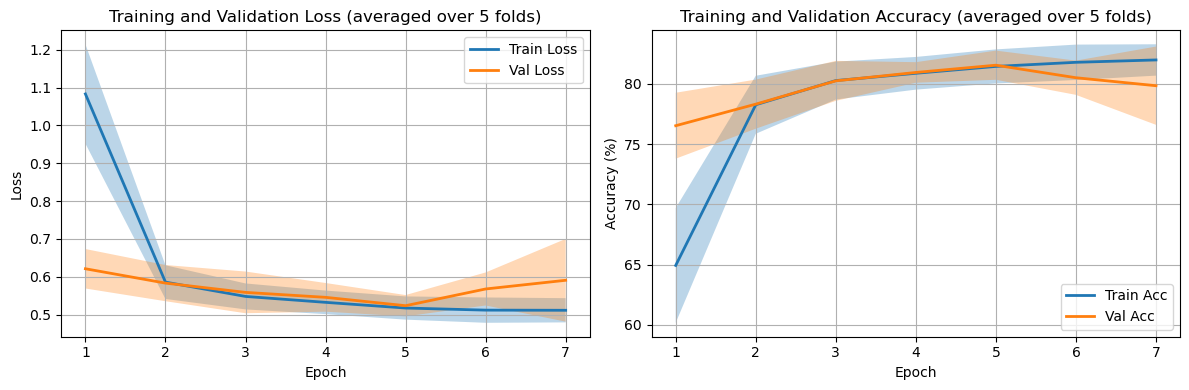


Average Results: Train Loss=0.5322, Val Loss=0.5735
                 Train Acc=81.75%, Val Acc=80.76%


In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Grid Search through learning rates
learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05]
weight_inits = ["random", "xavier"]

# Store results for plotting
results = {
    'random': {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []},
    'xavier': {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
}

for wi in weight_inits:
    print(f"\n{'*'*70}")
    print(f"WEIGHT INITIALIZATION: {wi.upper()}")
    print(f"{'*'*70}")
    
    for lr in learning_rates:
        print(f"\n{'='*60}")
        print(f"Testing Learning Rate: {lr} with {wi} initialization")
        
        trainer = TrainModel(
            learning_rate=lr,
            layer_sizes=(32, 32),
            optimizer="adam",
            activation="relu",
            weight_init=wi,
            device=device,
            visualize=True,
            verbose=0 
        )
        
        # Run k-fold cross validation
        fold_results = trainer.run_kfold_cv(
            training_data, 
            epochs=20, 
            batch_size=256, 
            patience=4
        )
        
        # Calculate average metrics across folds
        avg_train_loss = np.mean([r['history']['train_loss'][-1] for r in fold_results])
        avg_val_loss = np.mean([r['history']['val_loss'][-1] for r in fold_results])
        avg_train_acc = np.mean([r['final_train_acc'] for r in fold_results])
        avg_val_acc = np.mean([r['final_val_acc'] for r in fold_results])
        
        # Store results
        results[wi]['train_loss'].append(avg_train_loss)
        results[wi]['val_loss'].append(avg_val_loss)
        results[wi]['train_acc'].append(avg_train_acc)
        results[wi]['val_acc'].append(avg_val_acc)
        
        print(f"\nAverage Results: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")
        print(f"                 Train Acc={avg_train_acc:.2f}%, Val Acc={avg_val_acc:.2f}%")


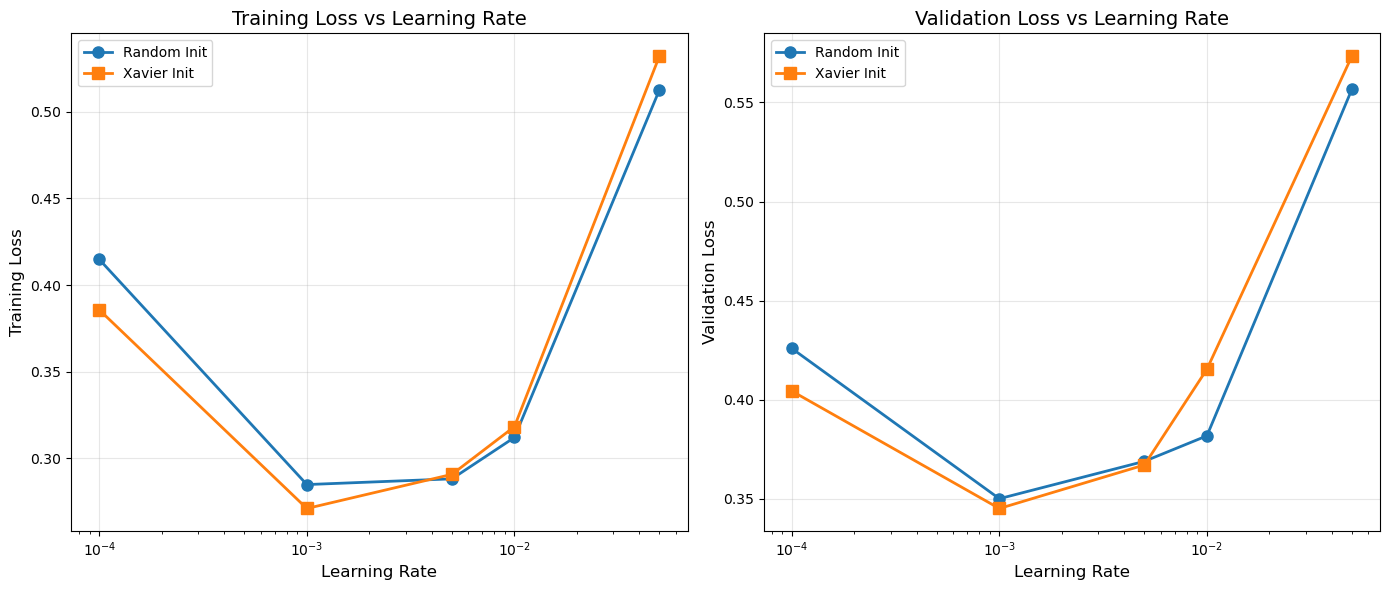


**********************************************************************
SUMMARY - BEST LEARNING RATES
**********************************************************************

RANDOM Initialization:
  Best Learning Rate: 0.001
  Best Validation Accuracy: 87.40%
  Training Accuracy: 89.59%
  Validation Loss: 0.3501

XAVIER Initialization:
  Best Learning Rate: 0.001
  Best Validation Accuracy: 87.73%
  Training Accuracy: 90.09%
  Validation Loss: 0.3451


In [7]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Training Loss vs Learning Rate
ax = axes[0]
ax.plot(learning_rates, results['random']['train_loss'], 'o-', label='Random Init', linewidth=2, markersize=8)
ax.plot(learning_rates, results['xavier']['train_loss'], 's-', label='Xavier Init', linewidth=2, markersize=8)
ax.set_xscale('log')
ax.set_xlabel('Learning Rate', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
ax.set_title('Training Loss vs Learning Rate', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Validation Loss vs Learning Rate
ax = axes[1]
ax.plot(learning_rates, results['random']['val_loss'], 'o-', label='Random Init', linewidth=2, markersize=8)
ax.plot(learning_rates, results['xavier']['val_loss'], 's-', label='Xavier Init', linewidth=2, markersize=8)
ax.set_xscale('log')
ax.set_xlabel('Learning Rate', fontsize=12)
ax.set_ylabel('Validation Loss', fontsize=12)
ax.set_title('Validation Loss vs Learning Rate', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('learning_rate_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print(f"\n{'*'*70}")
print("SUMMARY - BEST LEARNING RATES")
print(f"{'*'*70}")

for wi in weight_inits:
    best_val_idx = np.argmax(results[wi]['val_acc'])
    best_lr = learning_rates[best_val_idx]
    best_val_acc = results[wi]['val_acc'][best_val_idx]
    
    print(f"\n{wi.upper()} Initialization:")
    print(f"  Best Learning Rate: {best_lr}")
    print(f"  Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"  Training Accuracy: {results[wi]['train_acc'][best_val_idx]:.2f}%")
    print(f"  Validation Loss: {results[wi]['val_loss'][best_val_idx]:.4f}")

### Explore hyper-parameter choice-1
  * for hidden activation=relu, hidden layers = [64,64], optimizer=adam
  * Vary L1 and L2 in a 10x10 grid search (without dropout) 
  * Plot validation and training error as a function of L1 and L2 regularization in a 2D heatmap 
  * Plot the ratio (or difference) of validation to training error as a function of L1 and L2 regularization in a 2D heatmap 

In [8]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define L1 and L2 regularization values (10x10 grid)
l1_values = np.array([0.0, 0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1])
l2_values = np.array([0.0, 0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1])

print(f"L1 values: {l1_values}")
print(f"L2 values: {l2_values}")

# Store results in 2D arrays
train_loss_grid = np.zeros((len(l1_values), len(l2_values)))
val_loss_grid = np.zeros((len(l1_values), len(l2_values)))
train_acc_grid = np.zeros((len(l1_values), len(l2_values)))
val_acc_grid = np.zeros((len(l1_values), len(l2_values)))

# Grid search
total_iterations = len(l1_values) * len(l2_values)
current_iteration = 0

for i, l1 in enumerate(l1_values):
    for j, l2 in enumerate(l2_values):
        current_iteration += 1
        print(f"\n{'='*70}")
        print(f"Progress: {current_iteration}/{total_iterations} | Testing L1={l1:.6f}, L2={l2:.6f}")
        
        trainer = TrainModel(
            learning_rate=0.001,  
            layer_sizes=(64, 64),
            optimizer="adam",
            activation="relu",
            weight_init="xavier",  
            l1_lambda=l1,
            l2_lambda=l2,
            dropout_rate=0.0,  
            device=device,
            visualize=False,
            verbose=0
        )
        
        # Run k-fold cross validation
        fold_results = trainer.run_kfold_cv(
            training_data, 
            epochs=20, 
            batch_size=256, 
            patience=4
        )
        
        # Calculate average metrics across folds
        avg_train_loss = np.mean([r['history']['train_loss'][-1] for r in fold_results])
        avg_val_loss = np.mean([r['history']['val_loss'][-1] for r in fold_results])
        avg_train_acc = np.mean([r['final_train_acc'] for r in fold_results])
        avg_val_acc = np.mean([r['final_val_acc'] for r in fold_results])
        
        # Store in grids
        train_loss_grid[i, j] = avg_train_loss
        val_loss_grid[i, j] = avg_val_loss
        train_acc_grid[i, j] = avg_train_acc
        val_acc_grid[i, j] = avg_val_acc
        
        print(f"Results: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")
        print(f"         Train Acc={avg_train_acc:.2f}%, Val Acc={avg_val_acc:.2f}%")


Using cuda device
L1 values: [0.     0.0001 0.0005 0.001  0.002  0.005  0.01   0.02   0.05   0.1   ]
L2 values: [0.     0.0001 0.0005 0.001  0.002  0.005  0.01   0.02   0.05   0.1   ]

Progress: 1/100 | Testing L1=0.000000, L2=0.000000


Results: Train Loss=0.2262, Val Loss=0.3337
         Train Acc=91.71%, Val Acc=88.24%

Progress: 2/100 | Testing L1=0.000000, L2=0.000100
Results: Train Loss=0.2211, Val Loss=0.3227
         Train Acc=91.83%, Val Acc=88.68%

Progress: 3/100 | Testing L1=0.000000, L2=0.000500
Results: Train Loss=0.2377, Val Loss=0.3265
         Train Acc=91.30%, Val Acc=88.41%

Progress: 4/100 | Testing L1=0.000000, L2=0.001000
Results: Train Loss=0.2558, Val Loss=0.3288
         Train Acc=90.61%, Val Acc=88.08%

Progress: 5/100 | Testing L1=0.000000, L2=0.002000
Results: Train Loss=0.2833, Val Loss=0.3320
         Train Acc=89.70%, Val Acc=88.01%

Progress: 6/100 | Testing L1=0.000000, L2=0.005000
Results: Train Loss=0.3460, Val Loss=0.3737
         Train Acc=87.62%, Val Acc=86.64%

Progress: 7/100 | Testing L1=0.000000, L2=0.010000
Results: Train Loss=0.4099, Val Loss=0.4244
         Train Acc=85.59%, Val Acc=85.00%

Progress: 8/100 | Testing L1=0.000000, L2=0.020000
Results: Train Loss=0.4798, Val Lo

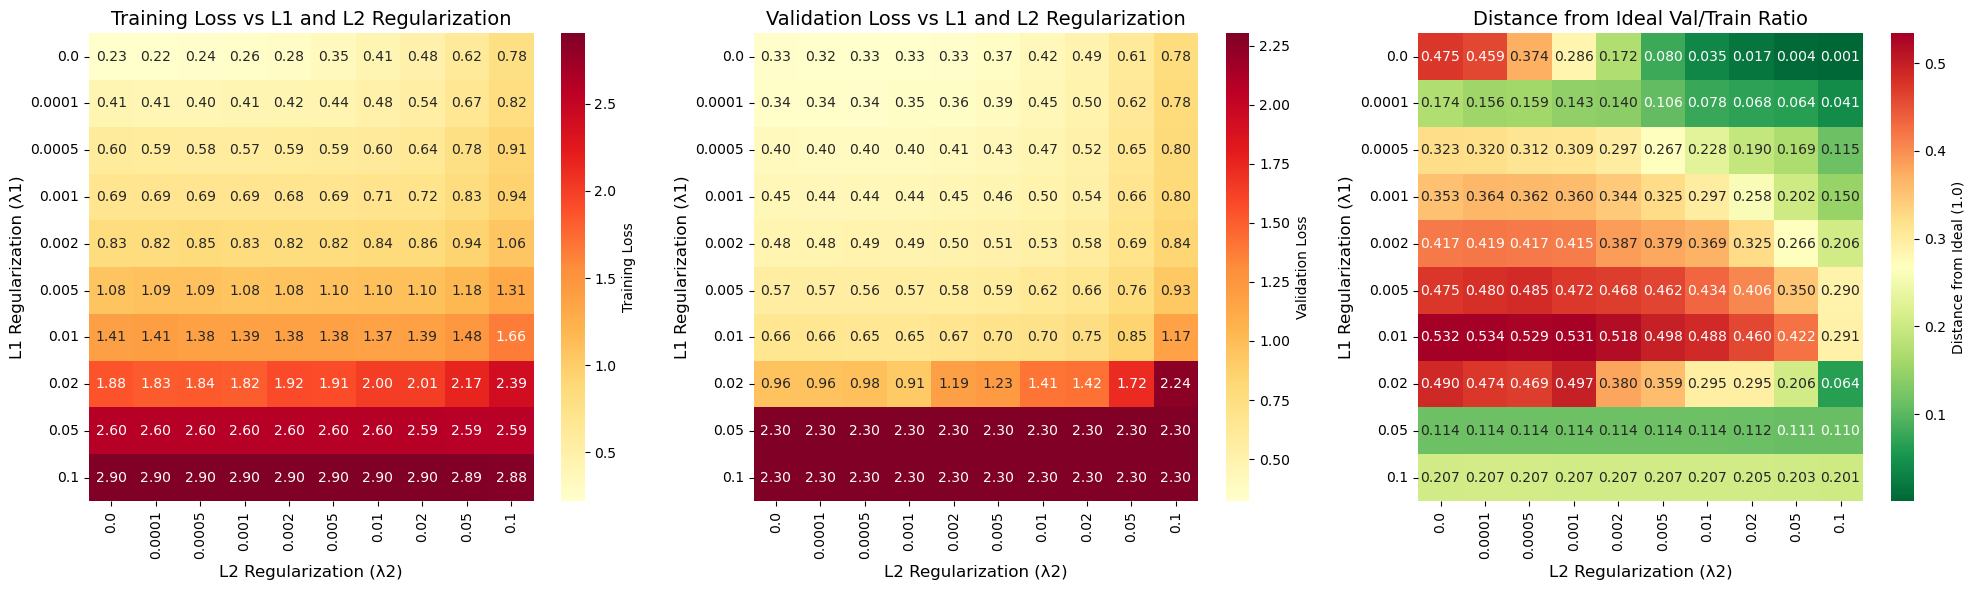


SUMMARY - BEST REGULARIZATION PARAMETERS

Best Configuration (highest validation accuracy):
  L1: 0.000000
  L2: 0.000100
  Training Loss: 0.2211
  Validation Loss: 0.3227
  Training Accuracy: 91.83%
  Validation Accuracy: 88.68%
  Val/Train Ratio: 1.459

Best Configuration (least overfitting - ratio closest to 1):
  L1: 0.000000
  L2: 0.100000
  Training Loss: 0.7769
  Validation Loss: 0.7763
  Training Accuracy: 75.05%
  Validation Accuracy: 75.18%
  Val/Train Ratio: 0.999

Results saved to 'l1_l2_grid_search_results.npz'


In [9]:
# Calculate validation/training error ratio
val_train_ratio_grid = val_loss_grid / train_loss_grid

# Create heatmaps (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Heatmap 1: Training Loss
ax = axes[0]
sns.heatmap(train_loss_grid, annot=True, fmt='.2f', cmap='YlOrRd', 
            xticklabels = l2_values, 
            yticklabels = l1_values,
            ax=ax, cbar_kws={'label': 'Training Loss'})
ax.set_xlabel('L2 Regularization (λ2)', fontsize=12)
ax.set_ylabel('L1 Regularization (λ1)', fontsize=12)
ax.set_title('Training Loss vs L1 and L2 Regularization', fontsize=14)

# Heatmap 2: Validation Loss
ax = axes[1]
sns.heatmap(val_loss_grid, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels = l2_values, 
            yticklabels = l1_values,
            ax=ax, cbar_kws={'label': 'Validation Loss'})
ax.set_xlabel('L2 Regularization (λ2)', fontsize=12)
ax.set_ylabel('L1 Regularization (λ1)', fontsize=12)
ax.set_title('Validation Loss vs L1 and L2 Regularization', fontsize=14)

# Calculate how far each value is from the ideal (1.0)
distance_from_ideal = np.abs(val_train_ratio_grid - 1.0)

# Heatmap 3: Distance from Ideal Ratio
ax = axes[2]
sns.heatmap(distance_from_ideal, annot=True, fmt='.3f', 
            cmap='RdYlGn_r',  # Green=close to 1 (small distance), Red=far from 1 (large distance)
            xticklabels=l2_values, 
            yticklabels=l1_values,
            ax=ax, cbar_kws={'label': 'Distance from Ideal (1.0)'})
ax.set_xlabel('L2 Regularization (λ2)', fontsize=12)
ax.set_ylabel('L1 Regularization (λ1)', fontsize=12)
ax.set_title('Distance from Ideal Val/Train Ratio', fontsize=14)

plt.tight_layout()
plt.savefig('l1_l2_regularization_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print(f"\n{'='*70}")
print("SUMMARY - BEST REGULARIZATION PARAMETERS")
print(f"{'='*70}")

# Find best based on validation accuracy
best_idx = np.unravel_index(np.argmax(val_acc_grid), val_acc_grid.shape)
best_l1 = l1_values[best_idx[0]]
best_l2 = l2_values[best_idx[1]]

print(f"\nBest Configuration (highest validation accuracy):")
print(f"  L1: {best_l1:.6f}")
print(f"  L2: {best_l2:.6f}")
print(f"  Training Loss: {train_loss_grid[best_idx]:.4f}")
print(f"  Validation Loss: {val_loss_grid[best_idx]:.4f}")
print(f"  Training Accuracy: {train_acc_grid[best_idx]:.2f}%")
print(f"  Validation Accuracy: {val_acc_grid[best_idx]:.2f}%")
print(f"  Val/Train Ratio: {val_train_ratio_grid[best_idx]:.3f}")

# Find configuration with best val/train ratio (closest to 1 = least overfitting)
ratio_diff = np.abs(val_train_ratio_grid - 1.0)
best_ratio_idx = np.unravel_index(np.argmin(ratio_diff), ratio_diff.shape)
best_ratio_l1 = l1_values[best_ratio_idx[0]]
best_ratio_l2 = l2_values[best_ratio_idx[1]]

print(f"\nBest Configuration (least overfitting - ratio closest to 1):")
print(f"  L1: {best_ratio_l1:.6f}")
print(f"  L2: {best_ratio_l2:.6f}")
print(f"  Training Loss: {train_loss_grid[best_ratio_idx]:.4f}")
print(f"  Validation Loss: {val_loss_grid[best_ratio_idx]:.4f}")
print(f"  Training Accuracy: {train_acc_grid[best_ratio_idx]:.2f}%")
print(f"  Validation Accuracy: {val_acc_grid[best_ratio_idx]:.2f}%")
print(f"  Val/Train Ratio: {val_train_ratio_grid[best_ratio_idx]:.3f}")

# Save results to file
np.savez('l1_l2_grid_search_results.npz',
         l1_values=l1_values,
         l2_values=l2_values,
         train_loss_grid=train_loss_grid,
         val_loss_grid=val_loss_grid,
         train_acc_grid=train_acc_grid,
         val_acc_grid=val_acc_grid,
         val_train_ratio_grid=val_train_ratio_grid)
print("\nResults saved to 'l1_l2_grid_search_results.npz'")

### Explore hyper-parameter choice-2
  * for hidden activation=sigmoid, hidden layers = [96,96,96], optimizer=**rmsprop**
  * Vary drop-out parameter in a 1x10 grid search (without L1 or L2 regularization) 
  * Plot training and validation error as a function of dropout rate  
  * Plot the ratio (or difference) of validation to training error as a function of dropout rate  


Using cuda device

Testing Dropout Rate: 0.0


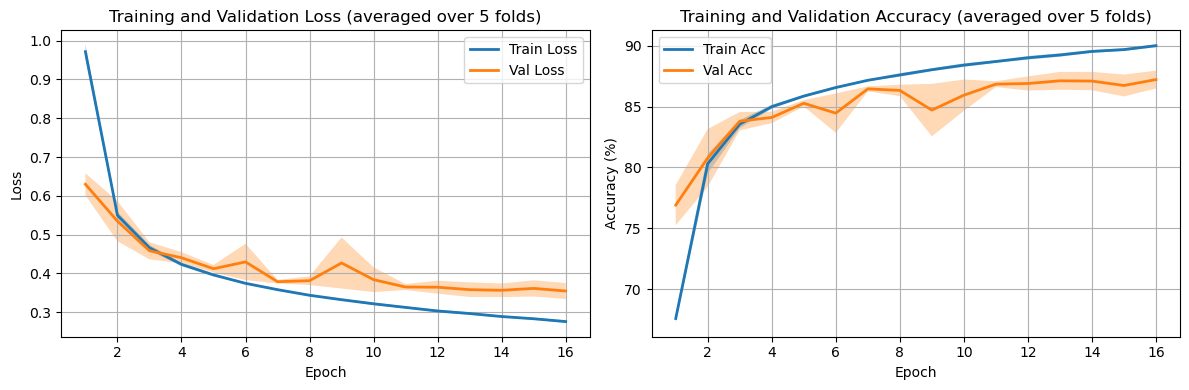


Average Results: Train Loss=0.2611, Val Loss=0.3577
                 Train Acc=90.48%, Val Acc=87.16%

Testing Dropout Rate: 0.1


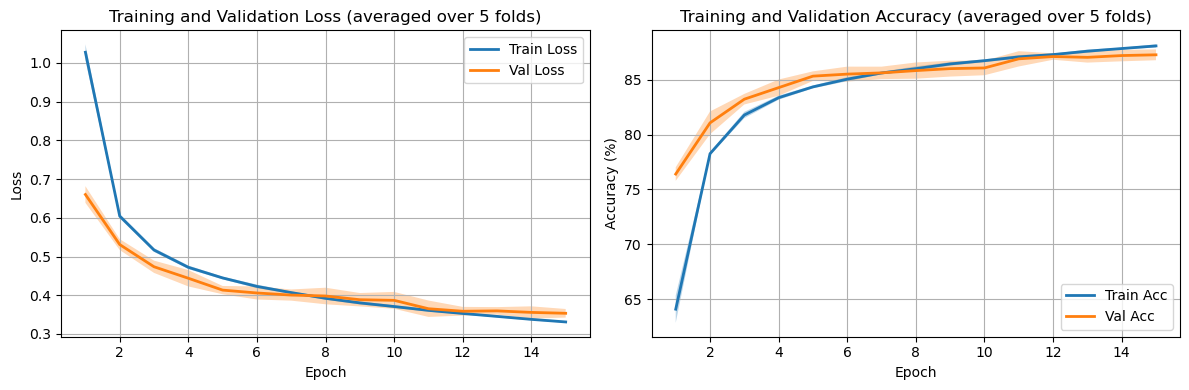


Average Results: Train Loss=0.3130, Val Loss=0.3694
                 Train Acc=88.66%, Val Acc=86.84%

Testing Dropout Rate: 0.2


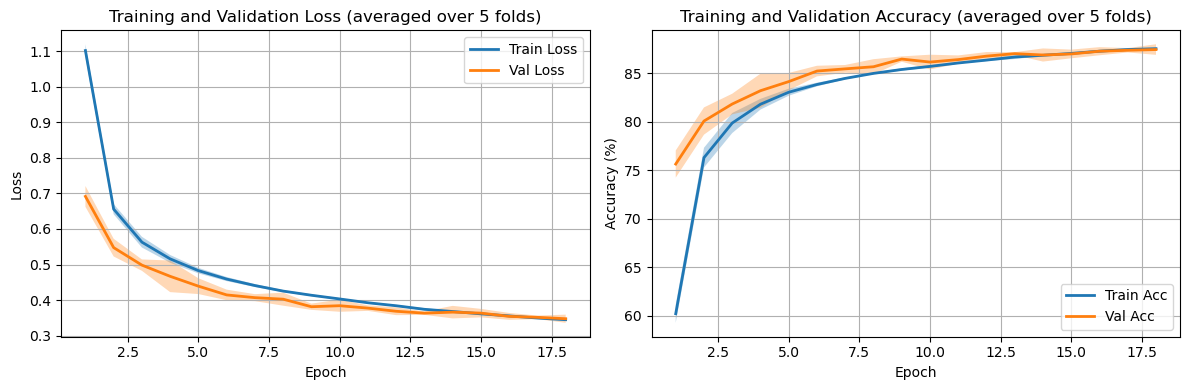


Average Results: Train Loss=0.3359, Val Loss=0.3420
                 Train Acc=87.85%, Val Acc=87.73%

Testing Dropout Rate: 0.3


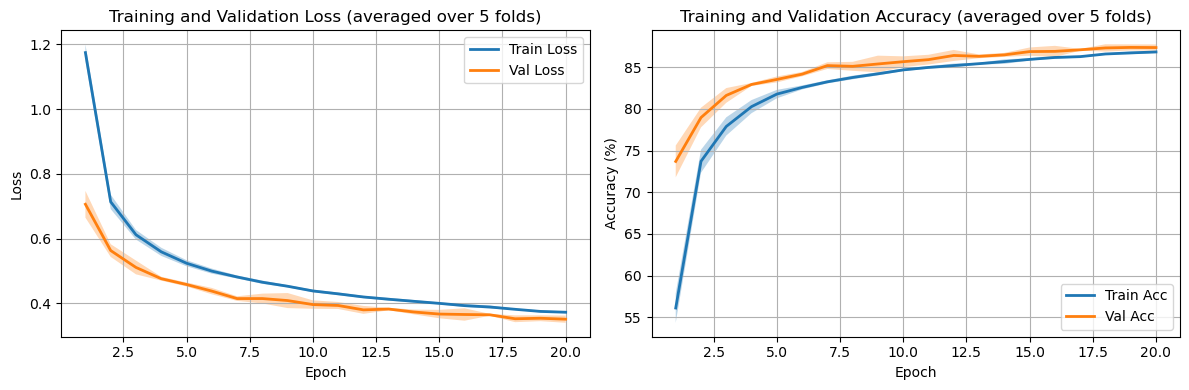


Average Results: Train Loss=0.3729, Val Loss=0.3515
                 Train Acc=86.81%, Val Acc=87.33%

Testing Dropout Rate: 0.4


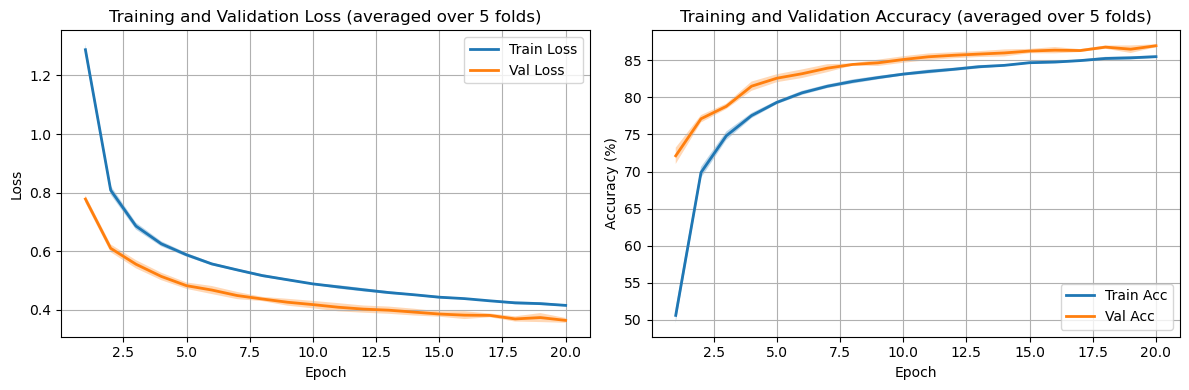


Average Results: Train Loss=0.4155, Val Loss=0.3644
                 Train Acc=85.47%, Val Acc=86.94%

Testing Dropout Rate: 0.5


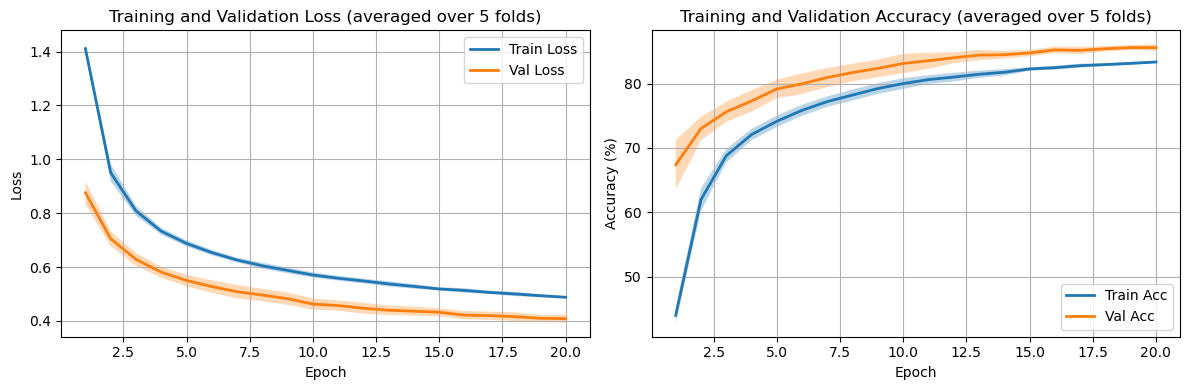


Average Results: Train Loss=0.4877, Val Loss=0.4082
                 Train Acc=83.35%, Val Acc=85.58%

Testing Dropout Rate: 0.6


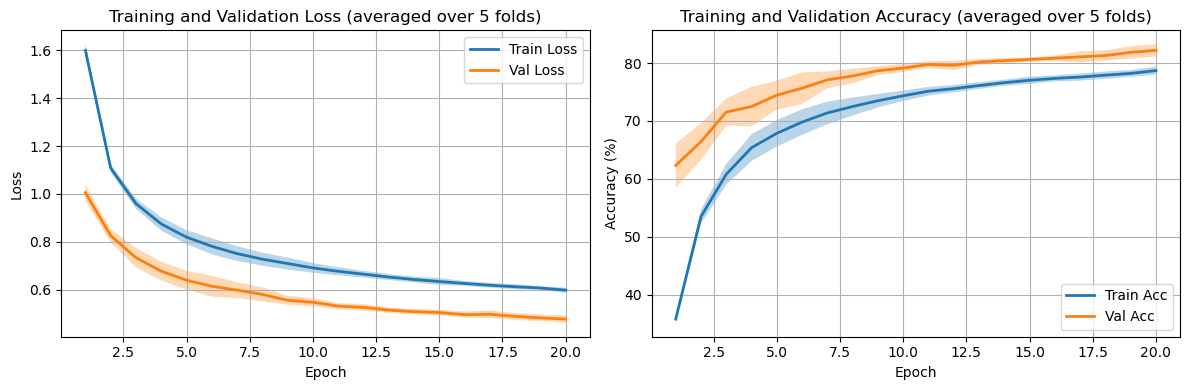


Average Results: Train Loss=0.5981, Val Loss=0.4774
                 Train Acc=78.69%, Val Acc=82.19%

Testing Dropout Rate: 0.7


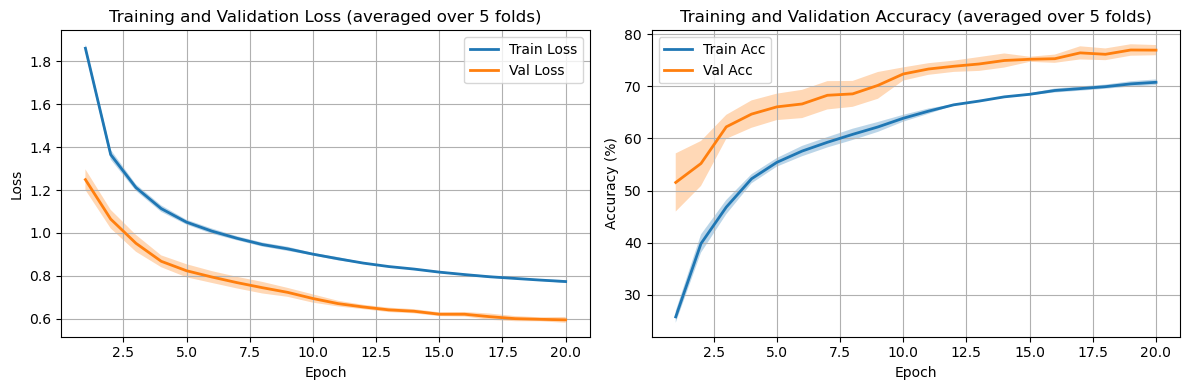


Average Results: Train Loss=0.7728, Val Loss=0.5941
                 Train Acc=70.75%, Val Acc=76.91%

Testing Dropout Rate: 0.8


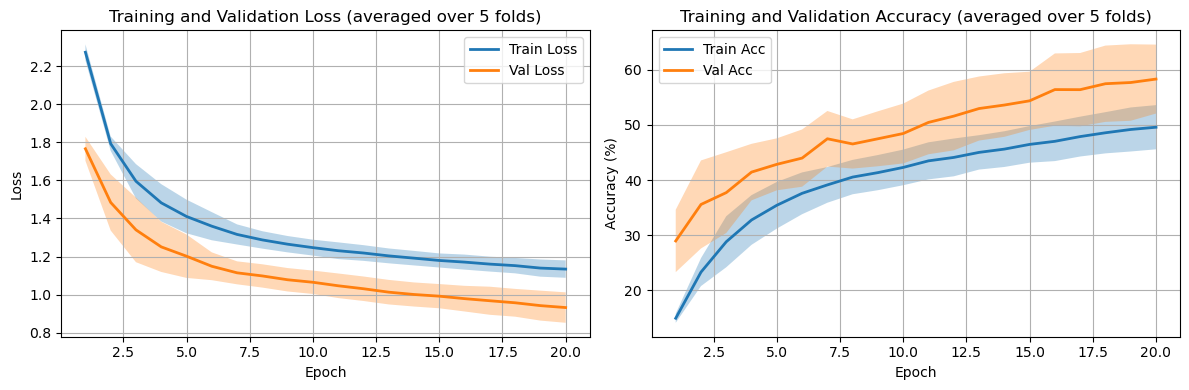


Average Results: Train Loss=1.1343, Val Loss=0.9323
                 Train Acc=49.59%, Val Acc=58.33%

Testing Dropout Rate: 0.9


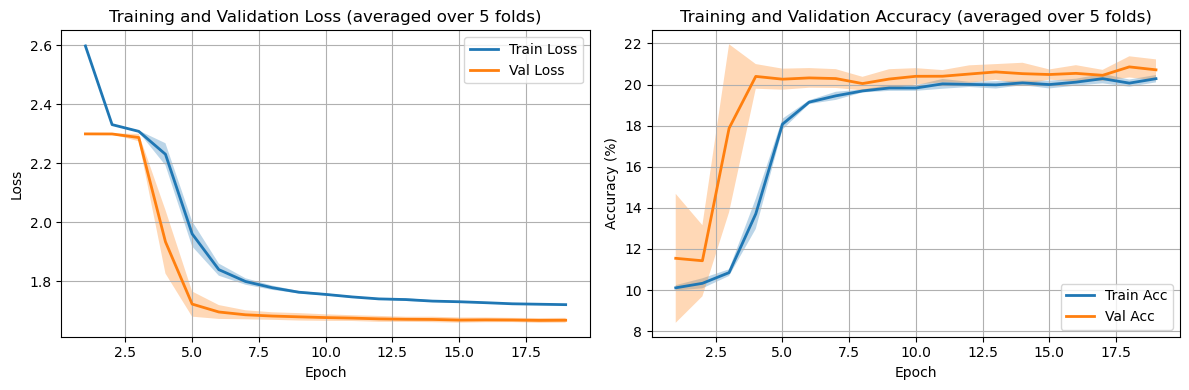


Average Results: Train Loss=1.7193, Val Loss=1.6662
                 Train Acc=20.32%, Val Acc=20.95%


In [8]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Grid Search through learning rates
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Store results for plotting
results = {
    'dropout': [],
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}
    
for do in dropout_rates:
    print(f"\n{'='*60}")
    print(f"Testing Dropout Rate: {do}")
    
    trainer = TrainModel(
        learning_rate=0.001,
        layer_sizes=(96, 96, 96),
        optimizer="rmsprop",
        activation="sigmoid",
        weight_init="xavier",
        dropout_rate=do,
        device=device,
        visualize=True,
        verbose=0 
    )
    
    # Run k-fold cross validation
    fold_results = trainer.run_kfold_cv(
        training_data, 
        epochs=20, 
        batch_size=256, 
        patience=4
    )
    
    # Store results
    avg_train_loss = np.mean([r['history']['train_loss'][-1] for r in fold_results])
    avg_val_loss = np.mean([r['history']['val_loss'][-1] for r in fold_results])
    avg_train_acc = np.mean([r['final_train_acc'] for r in fold_results])
    avg_val_acc = np.mean([r['final_val_acc'] for r in fold_results])
    
    results['dropout'].append(do)
    results['train_loss'].append(avg_train_loss)
    results['val_loss'].append(avg_val_loss)
    results['train_acc'].append(avg_train_acc)
    results['val_acc'].append(avg_val_acc)

    
    print(f"\nAverage Results: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")
    print(f"                 Train Acc={avg_train_acc:.2f}%, Val Acc={avg_val_acc:.2f}%")


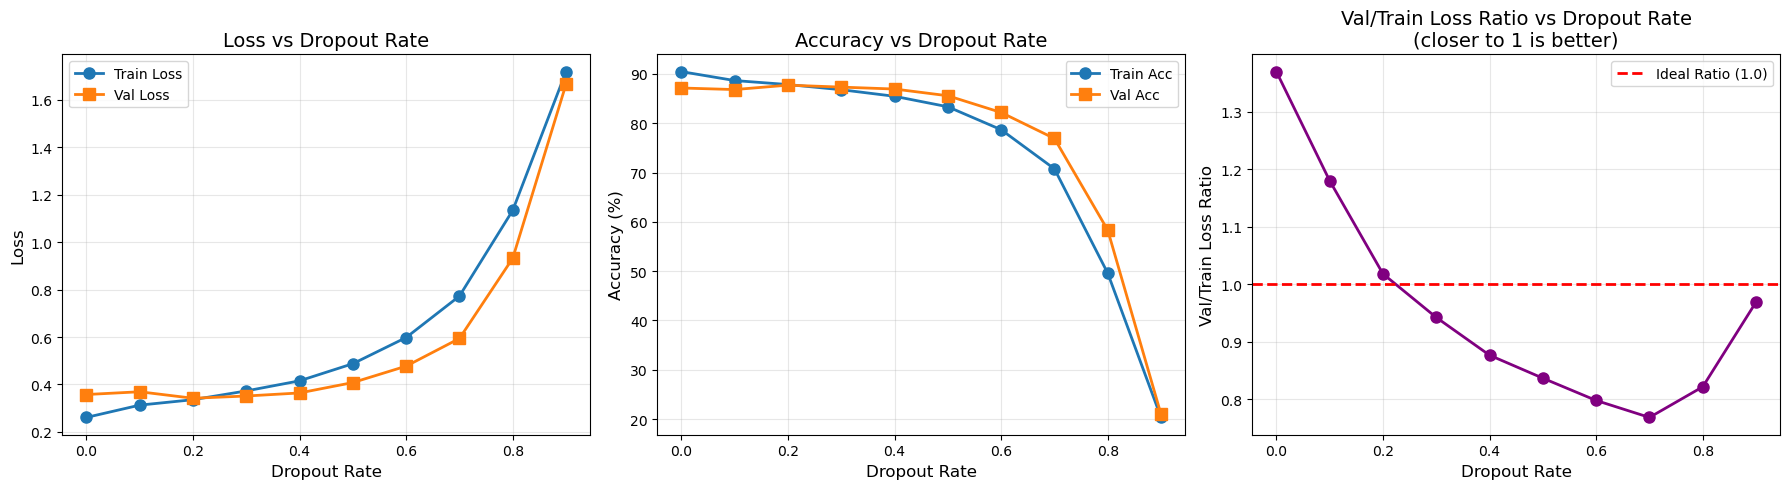


DROPOUT RATE ANALYSIS

Best Validation Accuracy:
  Dropout Rate: 0.2
  Val Accuracy: 87.73%
  Train Accuracy: 87.85%
  Val/Train Ratio: 1.018

Best Val/Train Ratio:
  Dropout Rate: 0.2
  Val/Train Ratio: 1.018
  Val Accuracy: 87.73%
  Train Accuracy: 87.85%

************************************************************
Best Balanced Configuration
************************************************************
  Dropout Rate: 0.2
  Val Accuracy: 87.73%
  Train Accuracy: 87.85%
  Val/Train Ratio: 1.018
  Val Loss: 0.3420

  This configuration balances high accuracy with good generalization.


In [10]:
# Calculate validation/training ratio
val_train_ratio = np.array(results['val_loss']) / np.array(results['train_loss'])

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Training and Validation Loss vs Dropout
ax = axes[0]
ax.plot(dropout_rates, results['train_loss'], 'o-', label='Train Loss', linewidth=2, markersize=8)
ax.plot(dropout_rates, results['val_loss'], 's-', label='Val Loss', linewidth=2, markersize=8)
ax.set_xlabel('Dropout Rate', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Loss vs Dropout Rate', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Training and Validation Accuracy vs Dropout
ax = axes[1]
ax.plot(dropout_rates, results['train_acc'], 'o-', label='Train Acc', linewidth=2, markersize=8)
ax.plot(dropout_rates, results['val_acc'], 's-', label='Val Acc', linewidth=2, markersize=8)
ax.set_xlabel('Dropout Rate', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Accuracy vs Dropout Rate', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Validation/Training Loss Ratio vs Dropout
ax = axes[2]
ax.plot(dropout_rates, val_train_ratio, 'o-', color='purple', linewidth=2, markersize=8)
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Ideal Ratio (1.0)')
ax.set_xlabel('Dropout Rate', fontsize=12)
ax.set_ylabel('Val/Train Loss Ratio', fontsize=12)
ax.set_title('Val/Train Loss Ratio vs Dropout Rate\n(closer to 1 is better)', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dropout_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print(f"\n{'='*60}")
print("DROPOUT RATE ANALYSIS")
print(f"{'='*60}")

best_val_acc_idx = np.argmax(results['val_acc'])
best_ratio_idx = np.argmin(np.abs(val_train_ratio - 1.0))  # Closest to 1

# Find best balanced dropout (good accuracy AND good ratio)
# Only consider configurations with val_acc > 80% (reasonable performance threshold)
valid_configs = np.where(np.array(results['val_acc']) > 80.0)[0]

if len(valid_configs) > 0:
    # Among valid configs, find the one with ratio closest to 1
    ratios_subset = val_train_ratio[valid_configs]
    best_balanced_idx_in_subset = np.argmin(np.abs(ratios_subset - 1.0))
    best_balanced_idx = valid_configs[best_balanced_idx_in_subset]
else:
    # Fallback if no configs meet threshold
    best_balanced_idx = best_val_acc_idx

print(f"\nBest Validation Accuracy:")
print(f"  Dropout Rate: {dropout_rates[best_val_acc_idx]}")
print(f"  Val Accuracy: {results['val_acc'][best_val_acc_idx]:.2f}%")
print(f"  Train Accuracy: {results['train_acc'][best_val_acc_idx]:.2f}%")
print(f"  Val/Train Ratio: {val_train_ratio[best_val_acc_idx]:.3f}")

print(f"\nBest Val/Train Ratio:")
print(f"  Dropout Rate: {dropout_rates[best_ratio_idx]}")
print(f"  Val/Train Ratio: {val_train_ratio[best_ratio_idx]:.3f}")
print(f"  Val Accuracy: {results['val_acc'][best_ratio_idx]:.2f}%")
print(f"  Train Accuracy: {results['train_acc'][best_ratio_idx]:.2f}%")

print(f"\n{'*'*60}")
print("Best Balanced Configuration")
print(f"{'*'*60}")
print(f"  Dropout Rate: {dropout_rates[best_balanced_idx]}")
print(f"  Val Accuracy: {results['val_acc'][best_balanced_idx]:.2f}%")
print(f"  Train Accuracy: {results['train_acc'][best_balanced_idx]:.2f}%")
print(f"  Val/Train Ratio: {val_train_ratio[best_balanced_idx]:.3f}")
print(f"  Val Loss: {results['val_loss'][best_balanced_idx]:.4f}")
print(f"\n  This configuration balances high accuracy with good generalization.")

### Explore hyper-parameter choice-3:
  * for hidden activation=relu, hidden layers = [96,96,96], optimizer=**adam**
  * Vary drop-out parameter in a 1x10 grid search (without L1 or L2 regularization) 
  * Plot training and validation as a function of dropout rate  
  * Plot the ratio (or difference) of validation to training error as a function of dropout rate  

In [11]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Grid Search through learning rates
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Store results for plotting
results = {
    'dropout': [],
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}
    
for do in dropout_rates:
    print(f"\n{'='*60}")
    print(f"Testing Dropout Rate: {do}")
    print(f"{'='*60}")
    
    trainer = TrainModel(
        learning_rate=0.001,
        layer_sizes=(96, 96, 96),
        optimizer="adam",
        activation="relu",
        weight_init="xavier",
        dropout_rate=do,
        device=device,
        visualize=False,
        verbose=1 
    )
    
    # Run k-fold cross validation
    fold_results = trainer.run_kfold_cv(
        training_data, 
        epochs=20, 
        batch_size=256, 
        patience=4
    )
    
    # Store results
    avg_train_loss = np.mean([r['history']['train_loss'][-1] for r in fold_results])
    avg_val_loss = np.mean([r['history']['val_loss'][-1] for r in fold_results])
    avg_train_acc = np.mean([r['final_train_acc'] for r in fold_results])
    avg_val_acc = np.mean([r['final_val_acc'] for r in fold_results])
    
    results['dropout'].append(do)
    results['train_loss'].append(avg_train_loss)
    results['val_loss'].append(avg_val_loss)
    results['train_acc'].append(avg_train_acc)
    results['val_acc'].append(avg_val_acc)

    
    print(f"\nAverage Results: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")
    print(f"                 Train Acc={avg_train_acc:.2f}%, Val Acc={avg_val_acc:.2f}%")

Using cuda device

Testing Dropout Rate: 0.0

*** FOLD 1/5 ***



Early stopping triggered after 12 epochs!
Best validation loss: 0.3239

Loaded best model from Epoch 12:
  Train Loss: 0.2385, Train Acc: 91.13%   Val Loss: 0.3290, Val Acc: 88.18%

*** FOLD 2/5 ***

Early stopping triggered after 18 epochs!
Best validation loss: 0.3202

Loaded best model from Epoch 18:
  Train Loss: 0.1897, Train Acc: 92.90%   Val Loss: 0.3283, Val Acc: 89.01%

*** FOLD 3/5 ***

Early stopping triggered after 13 epochs!
Best validation loss: 0.3318

Loaded best model from Epoch 10:
  Train Loss: 0.2541, Train Acc: 90.52%   Val Loss: 0.3362, Val Acc: 88.30%

*** FOLD 4/5 ***

Early stopping triggered after 14 epochs!
Best validation loss: 0.3105

Loaded best model from Epoch 10:
  Train Loss: 0.2504, Train Acc: 90.68%   Val Loss: 0.3105, Val Acc: 88.98%

*** FOLD 5/5 ***

Early stopping triggered after 15 epochs!
Best validation loss: 0.3078

Loaded best model from Epoch 15:
  Train Loss: 0.2148, Train Acc: 92.00%   Val Loss: 0.3213, Val Acc: 89.05%

K-FOLD CROSS VALI

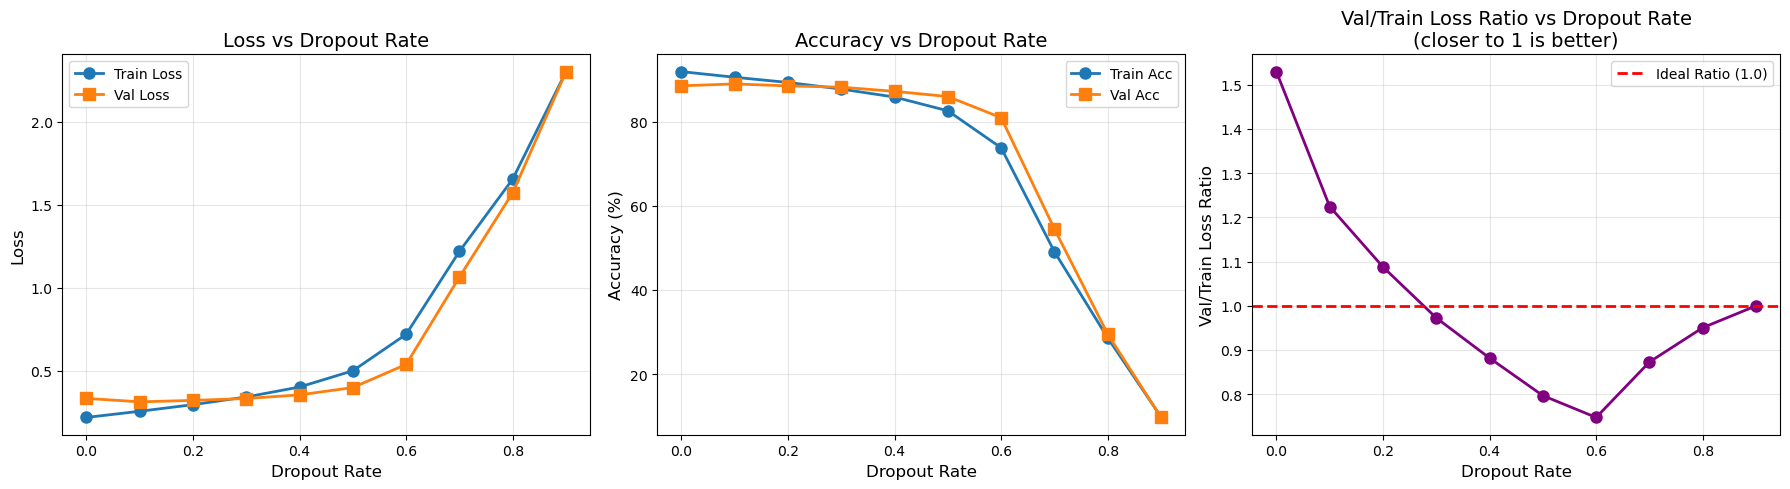


DROPOUT RATE ANALYSIS

Best Validation Accuracy (may overfit):
  Dropout Rate: 0.1
  Val Accuracy: 88.96%
  Train Accuracy: 90.54%
  Val/Train Ratio: 1.224

Best Val/Train Ratio (may underfit):
  Dropout Rate: 0.9
  Val/Train Ratio: 1.000
  Val Accuracy: 9.72%
  Train Accuracy: 9.85%

************************************************************
Best Balanced Configuration
************************************************************
  Dropout Rate: 0.3
  Val Accuracy: 88.18%
  Train Accuracy: 87.73%
  Val/Train Ratio: 0.973
  Val Loss: 0.3311

  This configuration balances high accuracy with good generalization.


In [ ]:
# Calculate validation/training ratio
val_train_ratio = np.array(results['val_loss']) / np.array(results['train_loss'])

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Training and Validation Loss vs Dropout
ax = axes[0]
ax.plot(dropout_rates, results['train_loss'], 'o-', label='Train Loss', linewidth=2, markersize=8)
ax.plot(dropout_rates, results['val_loss'], 's-', label='Val Loss', linewidth=2, markersize=8)
ax.set_xlabel('Dropout Rate', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Loss vs Dropout Rate', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Training and Validation Accuracy vs Dropout
ax = axes[1]
ax.plot(dropout_rates, results['train_acc'], 'o-', label='Train Acc', linewidth=2, markersize=8)
ax.plot(dropout_rates, results['val_acc'], 's-', label='Val Acc', linewidth=2, markersize=8)
ax.set_xlabel('Dropout Rate', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Accuracy vs Dropout Rate', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Validation/Training Loss Ratio vs Dropout
ax = axes[2]
ax.plot(dropout_rates, val_train_ratio, 'o-', color='purple', linewidth=2, markersize=8)
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Ideal Ratio (1.0)')
ax.set_xlabel('Dropout Rate', fontsize=12)
ax.set_ylabel('Val/Train Loss Ratio', fontsize=12)
ax.set_title('Val/Train Loss Ratio vs Dropout Rate\n(closer to 1 is better)', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dropout_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print(f"\n{'='*60}")
print("DROPOUT RATE ANALYSIS")
print(f"{'='*60}")

best_val_acc_idx = np.argmax(results['val_acc'])
best_ratio_idx = np.argmin(np.abs(val_train_ratio - 1.0))  # Closest to 1

# Find best balanced dropout (good accuracy AND good ratio)
# Only consider configurations with val_acc > 80% (reasonable performance threshold)
valid_configs = np.where(np.array(results['val_acc']) > 80.0)[0]

if len(valid_configs) > 0:
    # Among valid configs, find the one with ratio closest to 1
    ratios_subset = val_train_ratio[valid_configs]
    best_balanced_idx_in_subset = np.argmin(np.abs(ratios_subset - 1.0))
    best_balanced_idx = valid_configs[best_balanced_idx_in_subset]
else:
    # Fallback if no configs meet threshold
    best_balanced_idx = best_val_acc_idx

print(f"\nBest Validation Accuracy:")
print(f"  Dropout Rate: {dropout_rates[best_val_acc_idx]}")
print(f"  Val Accuracy: {results['val_acc'][best_val_acc_idx]:.2f}%")
print(f"  Train Accuracy: {results['train_acc'][best_val_acc_idx]:.2f}%")
print(f"  Val/Train Ratio: {val_train_ratio[best_val_acc_idx]:.3f}")

print(f"\nBest Val/Train Ratio:")
print(f"  Dropout Rate: {dropout_rates[best_ratio_idx]}")
print(f"  Val/Train Ratio: {val_train_ratio[best_ratio_idx]:.3f}")
print(f"  Val Accuracy: {results['val_acc'][best_ratio_idx]:.2f}%")
print(f"  Train Accuracy: {results['train_acc'][best_ratio_idx]:.2f}%")

print(f"\n{'*'*60}")
print("Best Balanced Configuration")
print(f"{'*'*60}")
print(f"  Dropout Rate: {dropout_rates[best_balanced_idx]}")
print(f"  Val Accuracy: {results['val_acc'][best_balanced_idx]:.2f}%")
print(f"  Train Accuracy: {results['train_acc'][best_balanced_idx]:.2f}%")
print(f"  Val/Train Ratio: {val_train_ratio[best_balanced_idx]:.3f}")
print(f"  Val Loss: {results['val_loss'][best_balanced_idx]:.4f}")
print(f"\n  This configuration balances high accuracy with good generalization.")

* `Optional` Systematically search for the best regularization parameters choice (3D search) using random search algorithm 
  * (https://en.wikipedia.org/wiki/Random_search)[https://en.wikipedia.org/wiki/Random_search]
  * Try to see how deep you can get the ANN (max hidden layers) without suffering from the vanishing gradient effect  
  
* `Final fit`
  * At the very end, select a best fit model and report, training, validation, and test errors at the very end
  * Make sure your "plotting variable=True" when for the final training

Using cuda device

TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS
Running 5-Fold Cross-Validation on Training Set...


*** FOLD 1/5 ***
Epoch 1/20 - Train Loss: 0.9595, Train Acc: 65.76% - Val Loss: 0.4958, Val Acc: 82.60%
Epoch 6/20 - Train Loss: 0.4492, Train Acc: 84.29% - Val Loss: 0.4011, Val Acc: 85.40%
Epoch 11/20 - Train Loss: 0.4141, Train Acc: 85.60% - Val Loss: 0.3569, Val Acc: 86.95%
Epoch 16/20 - Train Loss: 0.3994, Train Acc: 85.99% - Val Loss: 0.3490, Val Acc: 87.53%
Epoch 20/20 - Train Loss: 0.3927, Train Acc: 86.33% - Val Loss: 0.3457, Val Acc: 87.62%

Loaded best model from Epoch 20:
  Train Loss: 0.3927, Train Acc: 86.33%   Val Loss: 0.3457, Val Acc: 87.62%

Confusion Matrix for Fold 1:


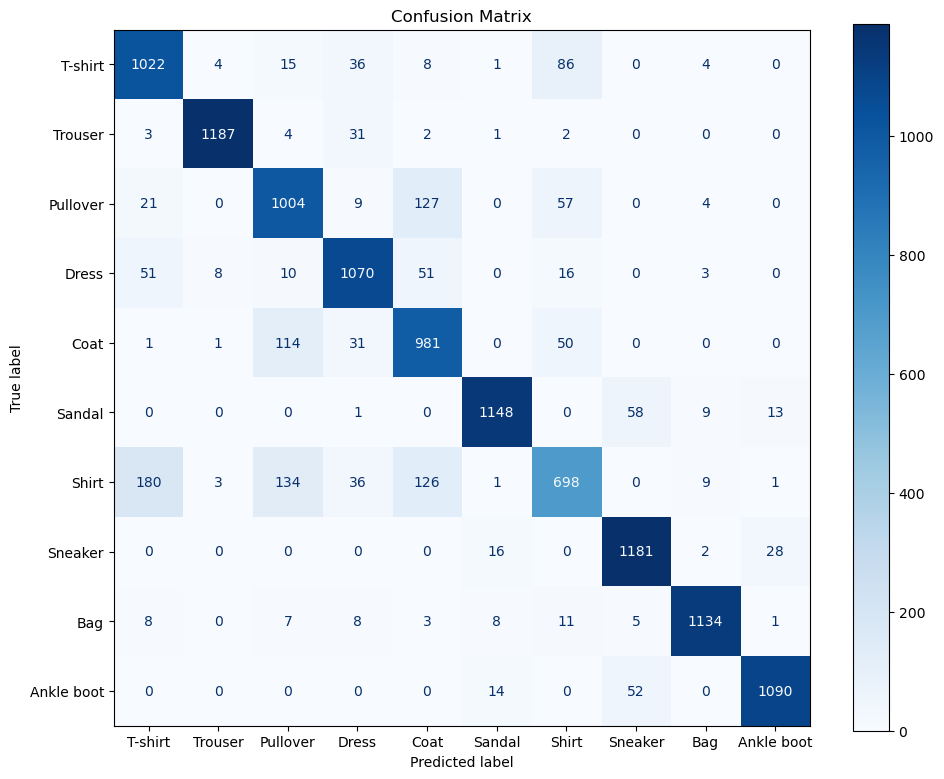


*** FOLD 2/5 ***
Epoch 1/20 - Train Loss: 0.9535, Train Acc: 65.89% - Val Loss: 0.5096, Val Acc: 81.72%
Epoch 6/20 - Train Loss: 0.4487, Train Acc: 84.35% - Val Loss: 0.3884, Val Acc: 86.16%
Epoch 11/20 - Train Loss: 0.4107, Train Acc: 85.61% - Val Loss: 0.3726, Val Acc: 86.81%
Epoch 16/20 - Train Loss: 0.3975, Train Acc: 86.10% - Val Loss: 0.3626, Val Acc: 86.99%
Epoch 20/20 - Train Loss: 0.3894, Train Acc: 86.46% - Val Loss: 0.3612, Val Acc: 86.93%

Loaded best model from Epoch 17:
  Train Loss: 0.3983, Train Acc: 85.99%   Val Loss: 0.3546, Val Acc: 87.35%

Confusion Matrix for Fold 2:


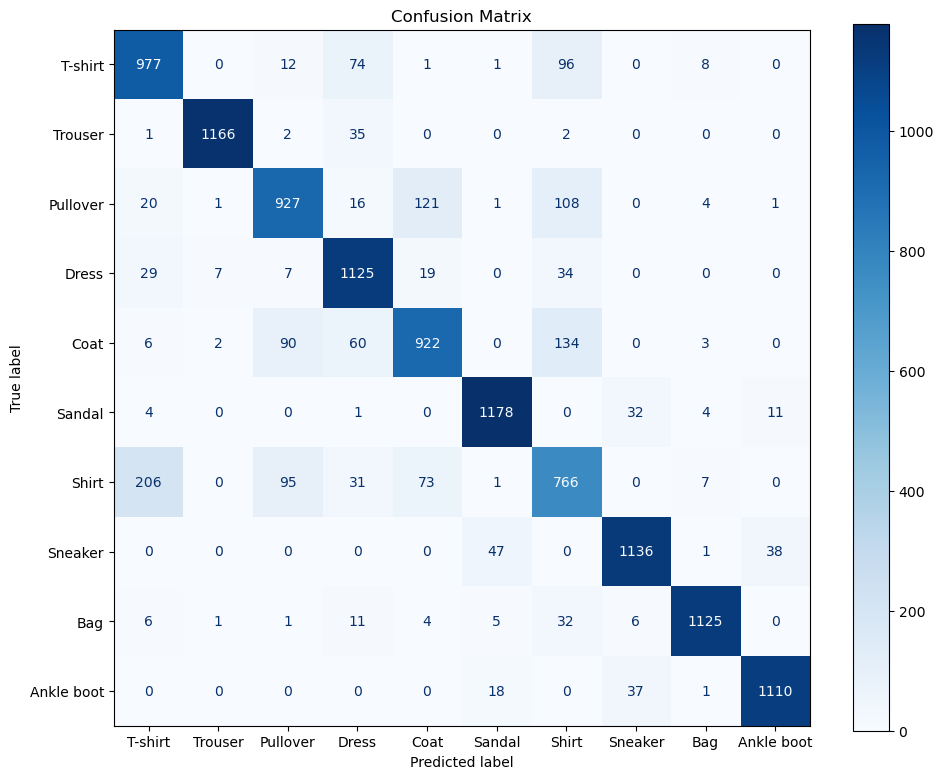


*** FOLD 3/5 ***
Epoch 1/20 - Train Loss: 0.9289, Train Acc: 66.50% - Val Loss: 0.5152, Val Acc: 81.33%
Epoch 6/20 - Train Loss: 0.4411, Train Acc: 84.42% - Val Loss: 0.3893, Val Acc: 85.82%
Epoch 11/20 - Train Loss: 0.4110, Train Acc: 85.55% - Val Loss: 0.4169, Val Acc: 84.62%
Epoch 16/20 - Train Loss: 0.3957, Train Acc: 85.97% - Val Loss: 0.3557, Val Acc: 87.23%
Epoch 20/20 - Train Loss: 0.3907, Train Acc: 86.40% - Val Loss: 0.3669, Val Acc: 86.96%

Loaded best model from Epoch 12:
  Train Loss: 0.4098, Train Acc: 85.72%   Val Loss: 0.3570, Val Acc: 87.42%

Confusion Matrix for Fold 3:


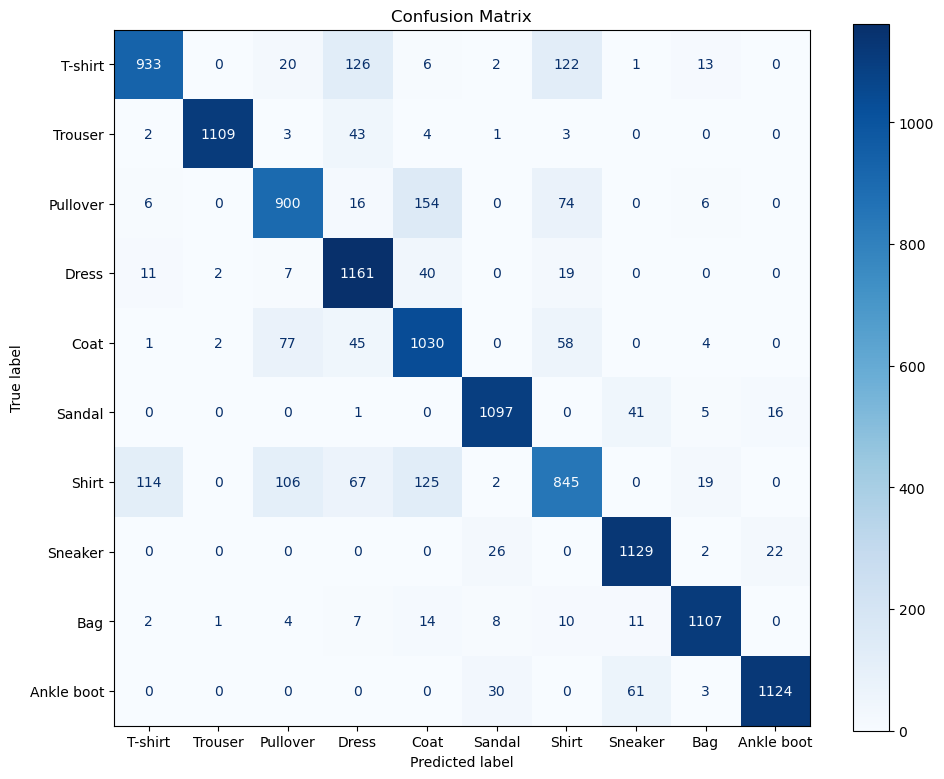


*** FOLD 4/5 ***
Epoch 1/20 - Train Loss: 0.9141, Train Acc: 67.09% - Val Loss: 0.4928, Val Acc: 82.08%
Epoch 6/20 - Train Loss: 0.4504, Train Acc: 84.21% - Val Loss: 0.3651, Val Acc: 86.62%
Epoch 11/20 - Train Loss: 0.4158, Train Acc: 85.24% - Val Loss: 0.3592, Val Acc: 87.08%
Epoch 16/20 - Train Loss: 0.4003, Train Acc: 85.94% - Val Loss: 0.3587, Val Acc: 86.72%
Epoch 20/20 - Train Loss: 0.3929, Train Acc: 86.34% - Val Loss: 0.3432, Val Acc: 87.65%

Loaded best model from Epoch 18:
  Train Loss: 0.3965, Train Acc: 86.08%   Val Loss: 0.3418, Val Acc: 87.76%

Confusion Matrix for Fold 4:


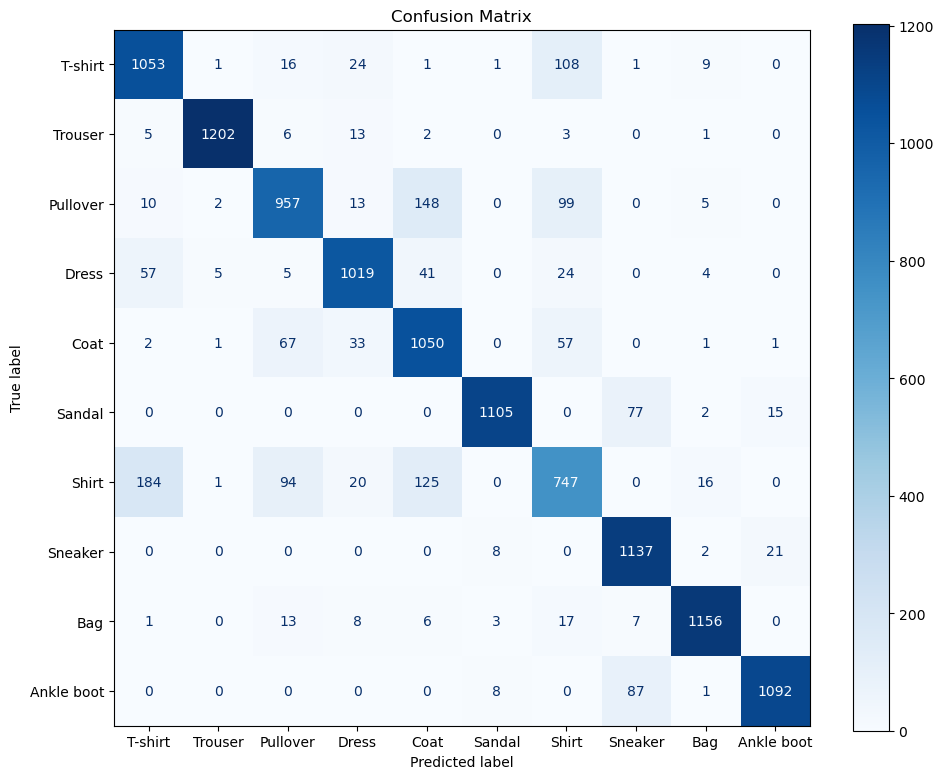


*** FOLD 5/5 ***
Epoch 1/20 - Train Loss: 0.9443, Train Acc: 65.76% - Val Loss: 0.4908, Val Acc: 82.62%
Epoch 6/20 - Train Loss: 0.4506, Train Acc: 84.32% - Val Loss: 0.3788, Val Acc: 86.24%
Epoch 11/20 - Train Loss: 0.4199, Train Acc: 85.41% - Val Loss: 0.3521, Val Acc: 87.17%
Epoch 16/20 - Train Loss: 0.4057, Train Acc: 85.80% - Val Loss: 0.3464, Val Acc: 87.57%
Epoch 20/20 - Train Loss: 0.3993, Train Acc: 85.98% - Val Loss: 0.3432, Val Acc: 87.71%

Loaded best model from Epoch 20:
  Train Loss: 0.3993, Train Acc: 85.98%   Val Loss: 0.3432, Val Acc: 87.71%

Confusion Matrix for Fold 5:


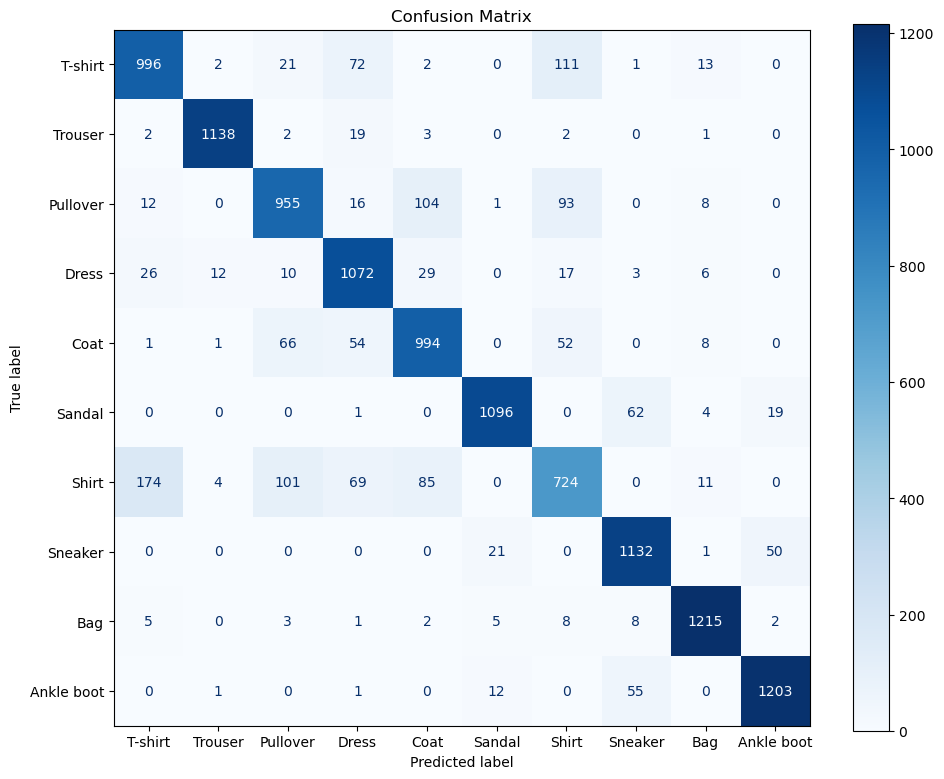

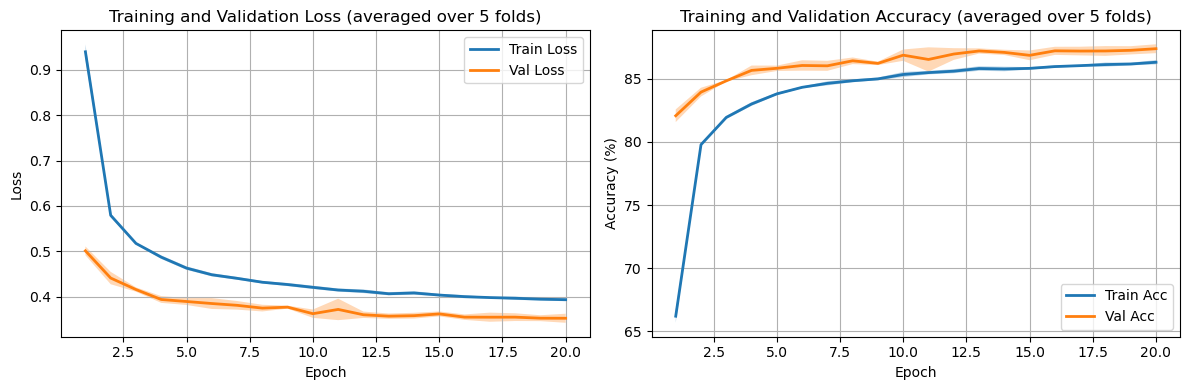


K-FOLD CROSS VALIDATION SUMMARY
Best Val Acc: 87.57% ± 0.16%
Final Epoch Val Acc: 87.37% ± 0.35%

CROSS-VALIDATION RESULTS
Mean Training Accuracy: 86.30%
Mean Validation Accuracy: 87.37%
Mean Best Validation Accuracy: 87.57%

TEST SET EVALUATION


Test Loss: 0.3686
Test Accuracy: 86.57%

Test Set Confusion Matrix:


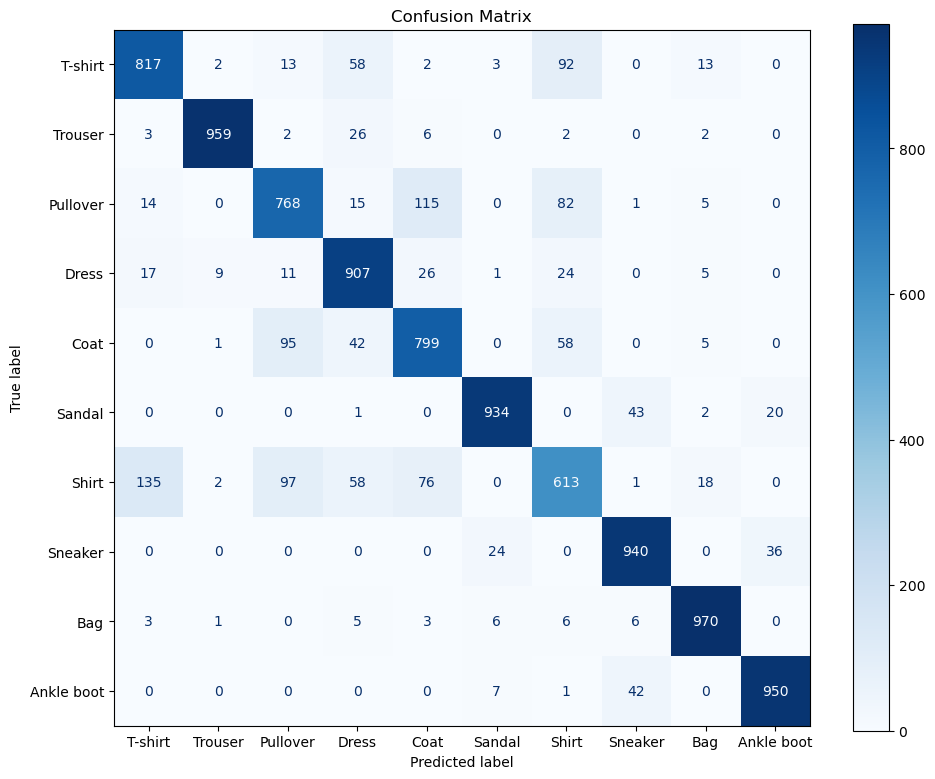


FINAL MODEL SUMMARY

Performance:
  Cross-Validation Accuracy: 87.57%
  Test Set Accuracy: 86.57%
  Test Set Loss: 0.3686

Overfitting Analysis:
  Train-Test Gap: -0.27%
  Status: Excellent generalization! ✓



In [ ]:
### Best Fit Model Hyper-Parameters
# Weights: Xavier 
# Learning Rate: 0.001
# Regularization: L1 = 0; L2 = 0.002?
# Activation: relu
# Hidden layers: [96,96,96]
# Optimizer: adam
# Dropout Rate: 0.3

# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

print(f"\n{'='*70}")
print("TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS")
print(f"{'='*70}")

# Create final model with best hyperparameters
final_model = TrainModel(
    learning_rate=0.001,
    layer_sizes=(96, 96, 96),
    optimizer="adam",
    activation="relu",
    weight_init="xavier",
    l1_lambda=0.0,
    l2_lambda=0.002,
    dropout_rate=0.3,
    device=device,
    visualize=True,        
    show_confusion=True,   
    verbose=2             
)

# Train on full training set using k-fold CV
print("Running 5-Fold Cross-Validation on Training Set...")
print(f"{'='*70}\n")

final_fold_results = final_model.run_kfold_cv(
    training_data,
    epochs=20,
    batch_size=256,
    patience=8
)

# Get average cross-validation performance
cv_train_acc = np.mean([r['final_train_acc'] for r in final_fold_results])
cv_val_acc = np.mean([r['final_val_acc'] for r in final_fold_results])
cv_best_val_acc = np.mean([r['best_val_acc'] for r in final_fold_results])

print(f"\n{'='*70}")
print("CROSS-VALIDATION RESULTS")
print(f"{'='*70}")
print(f"Mean Training Accuracy: {cv_train_acc:.2f}%")
print(f"Mean Validation Accuracy: {cv_val_acc:.2f}%")
print(f"Mean Best Validation Accuracy: {cv_best_val_acc:.2f}%")

# Evaluate on test set
print(f"\n{'='*70}")
print("TEST SET EVALUATION")
print(f"{'='*70}\n")

# Create test loader
if device == "cuda":
    test_loader = DataLoader(
        test_data,
        batch_size=256,
        shuffle=False,
        num_workers=8,
        pin_memory=True
    )
else:
    test_loader = DataLoader(
        test_data,
        batch_size=256,
        shuffle=False
    )

# Evaluate and show confusion matrix
test_loss, test_acc = final_model.evaluate_test_set(test_loader)

# Final summary
print(f"\n{'='*70}")
print("FINAL MODEL SUMMARY")
print(f"{'='*70}")

print(f"\nPerformance:")
print(f"  Cross-Validation Accuracy: {cv_best_val_acc:.2f}%")
print(f"  Test Set Accuracy: {test_acc:.2f}%")
print(f"  Test Set Loss: {test_loss:.4f}")

print(f"\nOverfitting Analysis:")
train_test_gap = cv_train_acc - test_acc
print(f"  Train-Test Gap: {train_test_gap:.2f}%")
if train_test_gap < 2.0:
    print(f"  Status: Excellent generalization! ✓")
elif train_test_gap < 5.0:
    print(f"  Status: Good generalization ✓")
else:
    print(f"  Status: Some overfitting detected")

print(f"{'='*70}\n")

# Save the model 
# torch.save(final_model.model.state_dict(), 'best_fashion_mnist_model.pth')
# print("Model saved to 'best_fashion_mnist_model.pth'")